In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pylab as pl

from sklearn.cross_validation import cross_val_score 
from sklearn.cross_validation import KFold
import sklearn.preprocessing as pp
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
import sklearn.decomposition
import sklearn.ensemble as sk
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.grid_search import GridSearchCV

import random
import sys
from scipy import stats
% matplotlib inline
%load_ext autoreload
%autoreload 2
from regression_functions import *
from reg_plots import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Data

In [148]:
pod_number = 'cham_2'

In [149]:
df_all = pd.io.parsers.read_csv(filepath_or_buffer = 'data/7_25_all_lim.csv', parse_dates = [0], index_col = 0)
df_all = df_all.rename(columns={'o3_ppb': 'O3_ppb'})

In [150]:
df_all.O3_ppb = df_all.O3_ppb.shift(-1)

#### Declare whether to process raw or filtered data.

In [151]:
which_data = 0    #1 = filtered, 0 = raw
ref_column, leave_out_pod, pod_ozone = declare_filt_or_raw_dataset(which_data)

#### Call the scaling function and create a dataframe with scaled data.

In [152]:
df_scaled, features, minmax_scale_fit, standard_scale_fit = scale_features_and_create_day_column(df_all, ref_column)
len(df_scaled)

6108

#### Declare whether you'd like to use holdout dates from a previous run.

In [153]:
prev_holdout = "false"
chunks = ['8-12 AM']

#### Add a 'day' column to the dataframe, and separate the data into training and holdout.

In [154]:
if prev_holdout == "true":
    df_tr, df_hold, chunks_tr, days_tr = sep_tr_and_holdout_pre_defined(df_scaled, ref_column, chunks)
else:
    df_tr, df_hold, chunks_tr, days_tr = sep_tr_and_holdout(df_scaled, ref_column)

['7-26 PM' '7-27 AM' '7-27 PM' '7-28 AM' '7-28 PM' '7-29 AM' '7-31 AM'
 '7-31 PM' '8-1 AM' '8-1 PM' '8-2 AM' '8-2 PM' '8-3 AM' '8-3 PM' '8-4 AM'
 '8-4 PM' '8-5 AM' '8-5 PM' '8-6 AM' '8-6 PM' '8-7 AM' '8-7 PM' '8-8 AM'
 '8-8 PM' '8-9 AM' '8-9 PM' '8-10 AM' '8-10 PM' '8-11 AM' '8-11 PM'
 '8-12 AM']


In [155]:
df_hold['chunk'].unique()

array(['7-29 AM', '8-1 PM', '8-9 AM', '8-10 AM'], dtype=object)

###Declare a cutoff value for 'high' ozone.

In [156]:
cutoff_value = 50

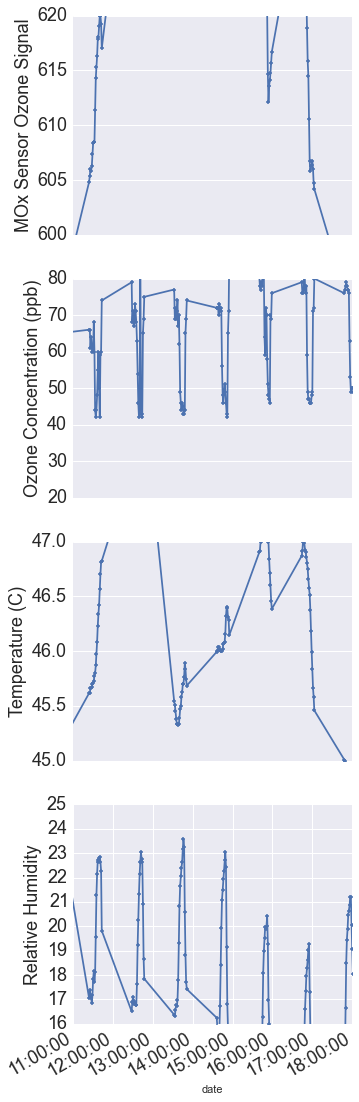

In [157]:
plot_03_temp_rh_no_scale(df_all, pod_number, ref_column, 'Training Data', cutoff_value, 5)

#### Plot the training ozone

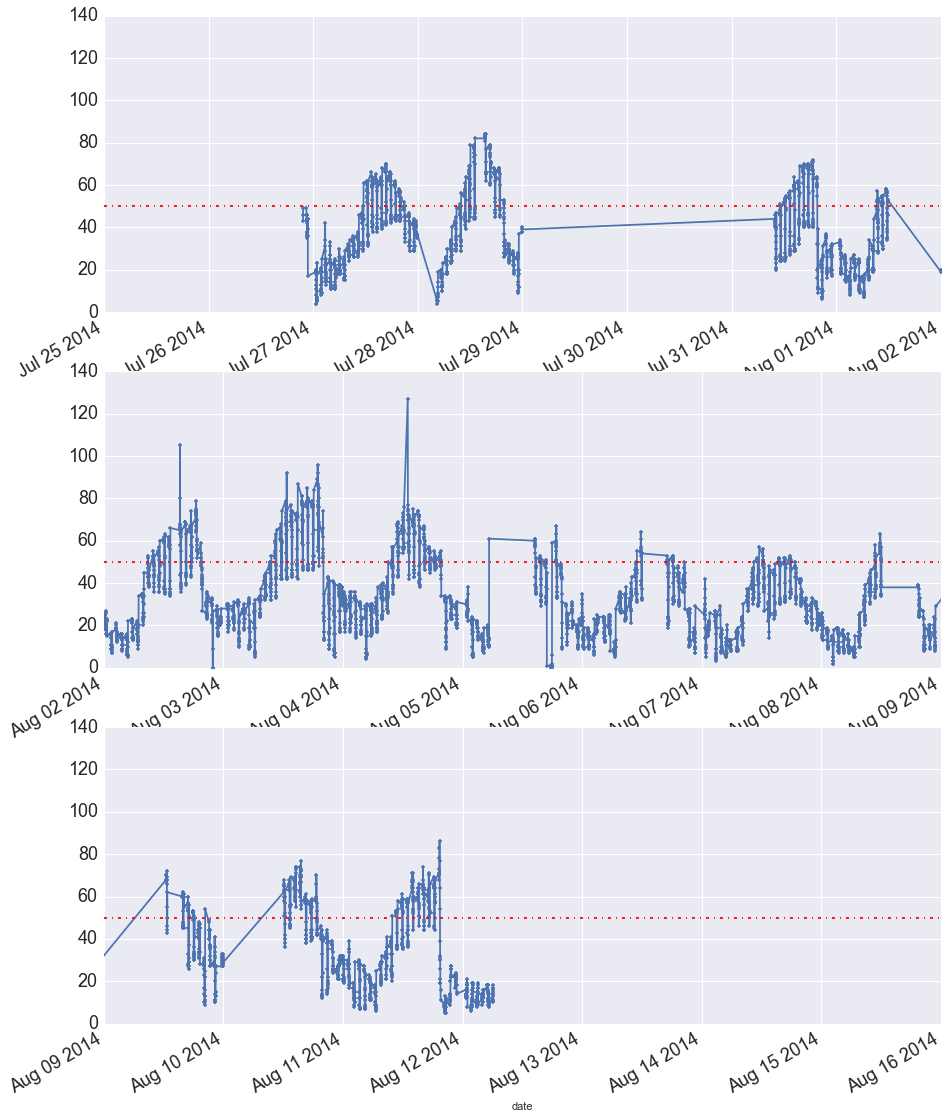

In [158]:
plot_tr_and_holdout(df_tr, pod_number, ref_column, 'Training Data', cutoff_value)

###Plot holdout ozone to make sure that the holdout set has some high-value ozone measurements.

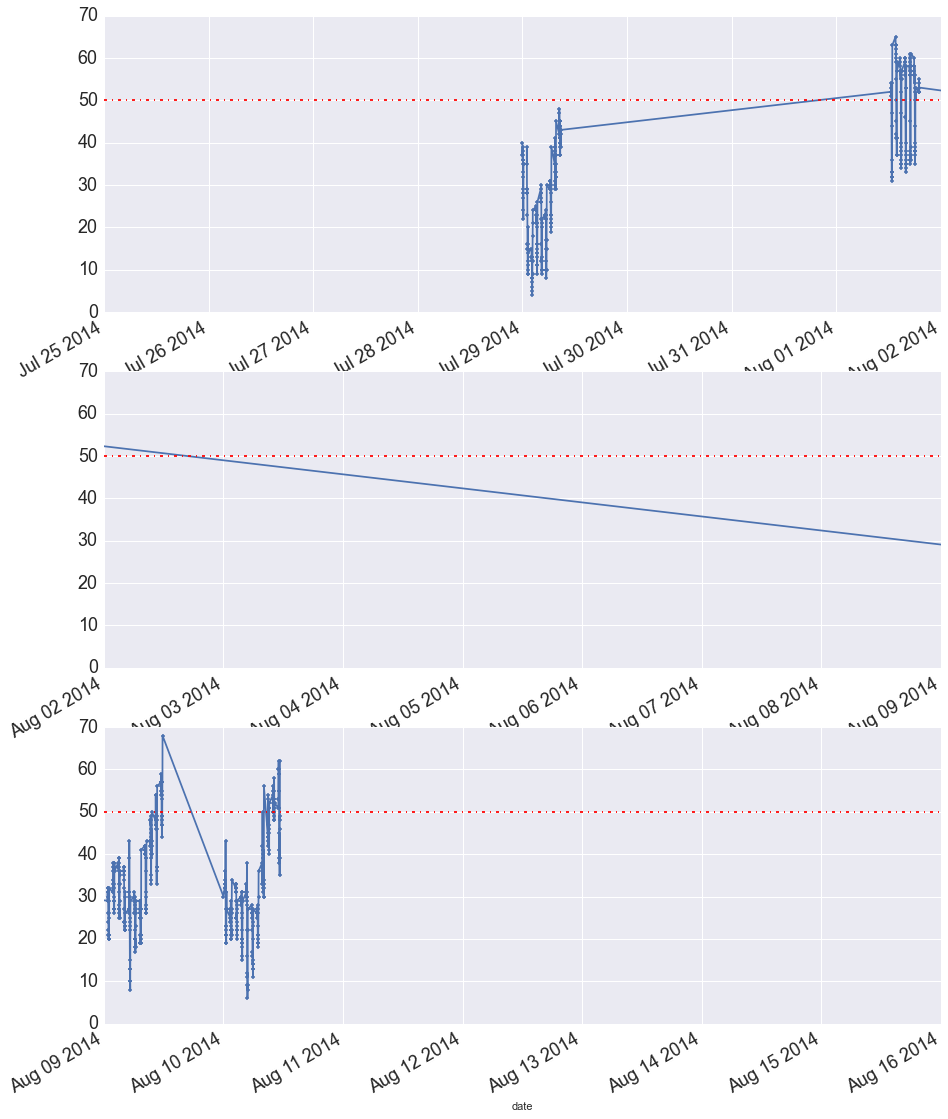

In [159]:
plot_tr_and_holdout(df_hold, pod_number, ref_column, 'Holdout Data', cutoff_value)

#### Declare a multiplication factor for the MSE part of the custom score function.

In [160]:
cust_mse_fact = 1

#### Linear Regression with Base Features

In [161]:
base_features = [pod_ozone,'Temp','Rh', 'no2']

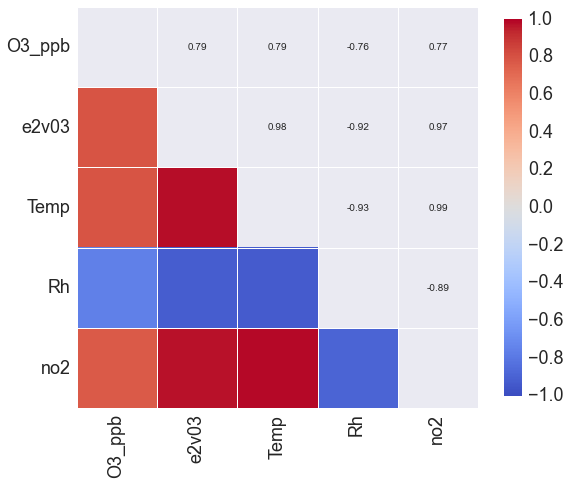

In [162]:
f, ax = plt.subplots(figsize=(9, 9))
sns.corrplot(df_tr[[ref_column] + base_features], annot=True, sig_stars=False,
             diag_names=False, ax=ax)

In [163]:
df_tr = df_tr[np.isnan(df_tr[ref_column]) == False]

In [164]:
df_scaled = df_scaled[np.isnan(df_scaled[ref_column]) == False]

In [165]:
#Define the model.
lin_regr = linear_model.LinearRegression()
#find the MSE
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_base, y_cv, df_cv_lin_base, df_H_lin_base = cross_validation_by_day(lin_regr, base_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 11.0
Cross-Validation RMSE: 12.0 , High-Value CV RMSE: 14.0 , CV High Diff. in Mean (>50): -10.3
Holdout RMSE: 9.0 , High-Value Holdout RMSE: 8.0 , Holdout High Diff. in Mean.: -4.8


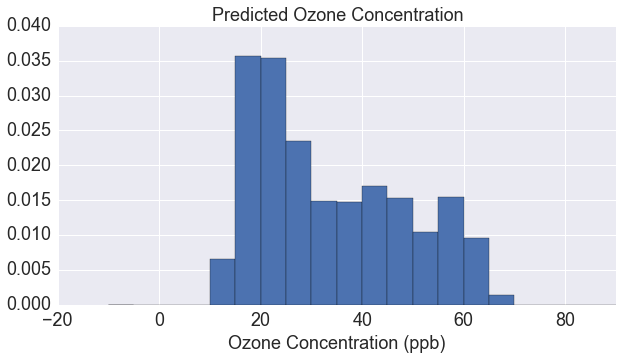

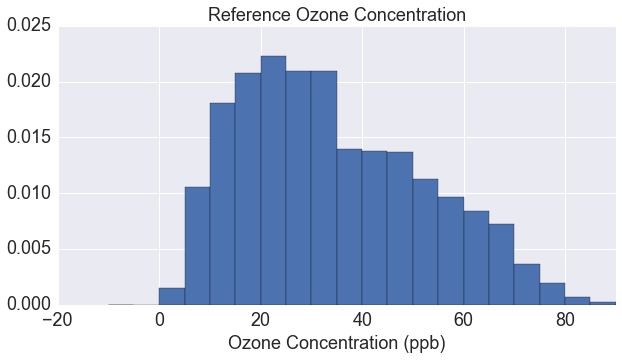

In [166]:
plot_hist(X_pred_cv_base, y_cv, 'Predicted Ozone Concentration')
plot_hist(y_cv, X_pred_cv_base, 'Reference Ozone Concentration')

#### Plot the learning curve for a linear regression with the base features.

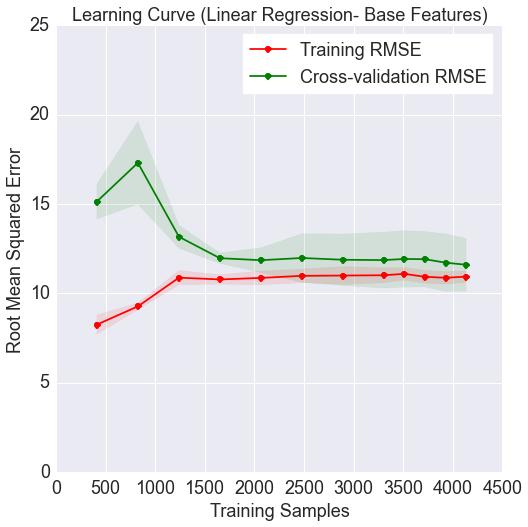

In [167]:
plt = plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- Base Features)", df_tr[base_features].values, df_tr[ref_column].values, (0,25), days_tr, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]))

The MSE is high for the cross-validation set in this plot, and the training and cross-validation scores come together in this plot tells us that we have resonably high bias. Create more features and add polynomial effects to reduce bias. 

#### Plot the residuals and comparison curves.

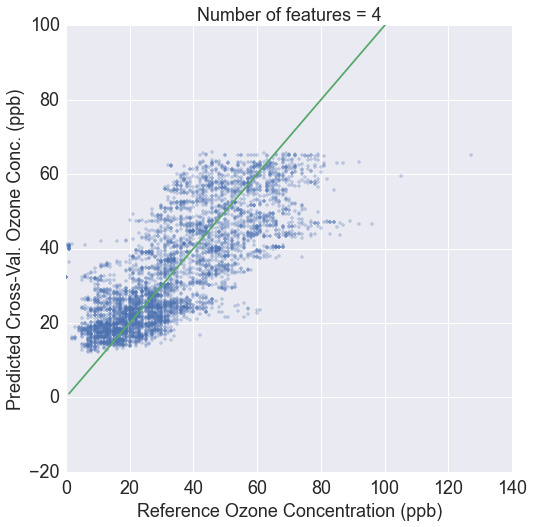

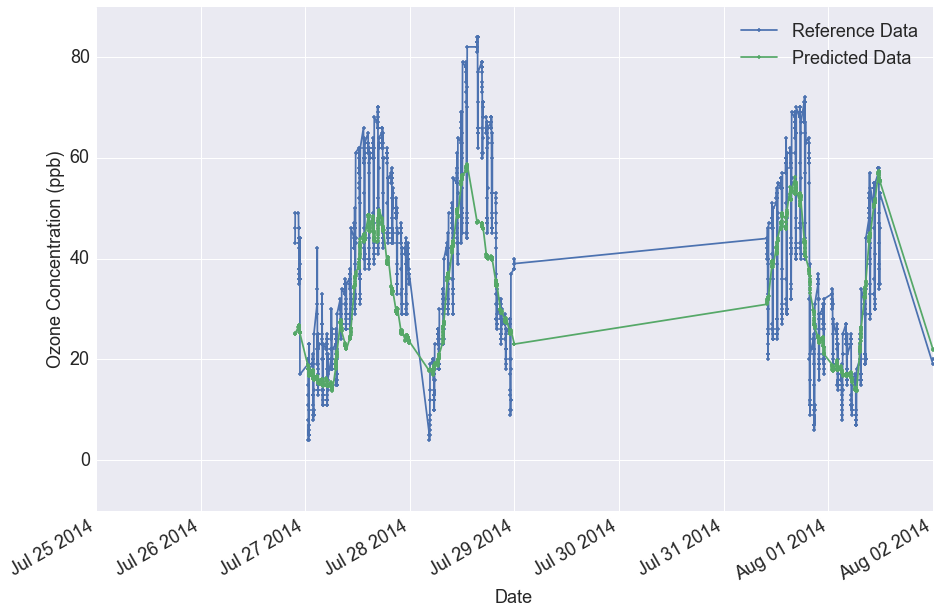

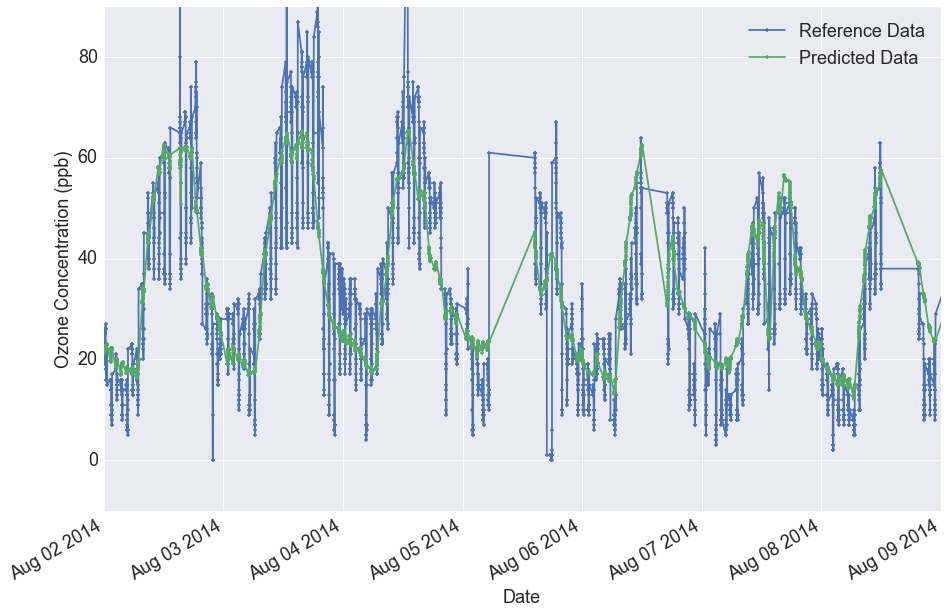

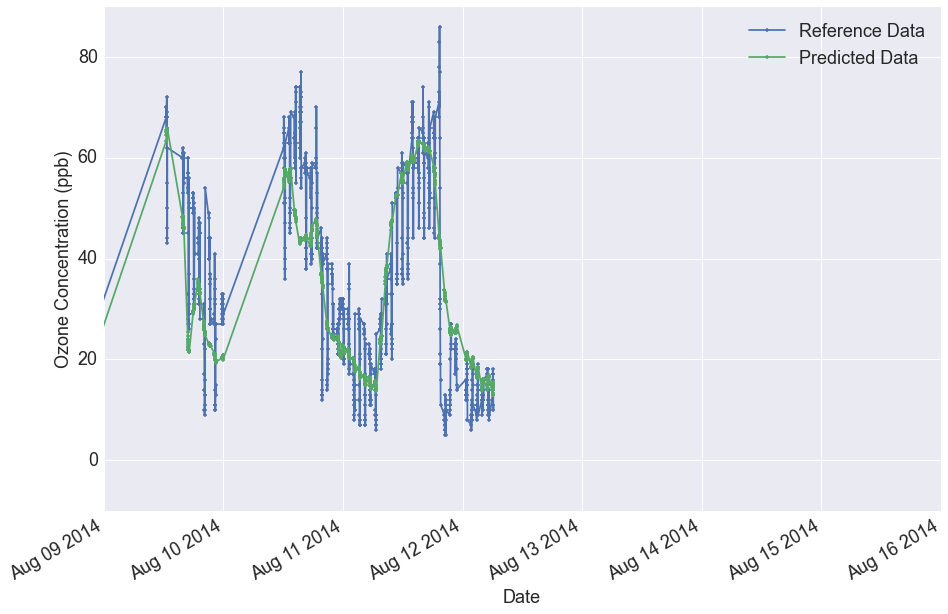

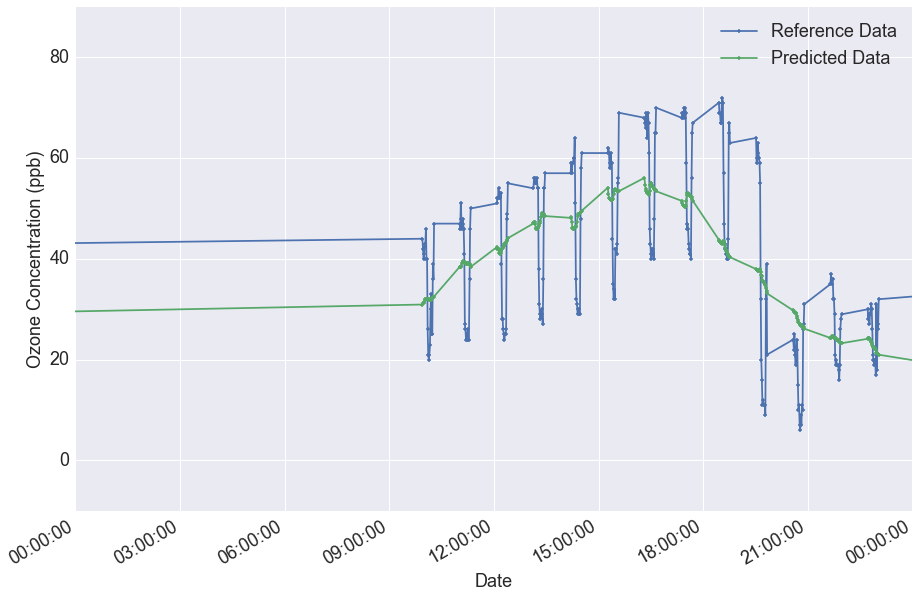

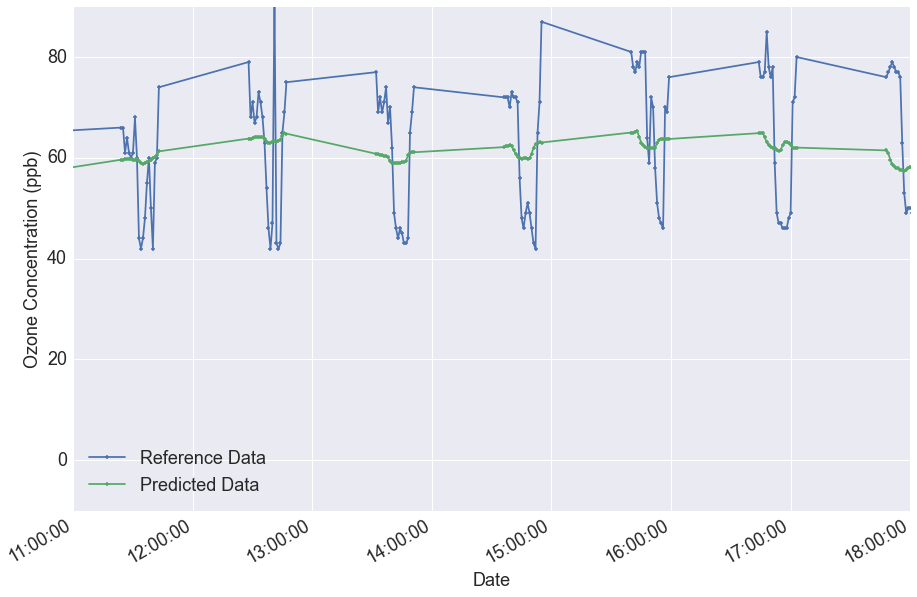

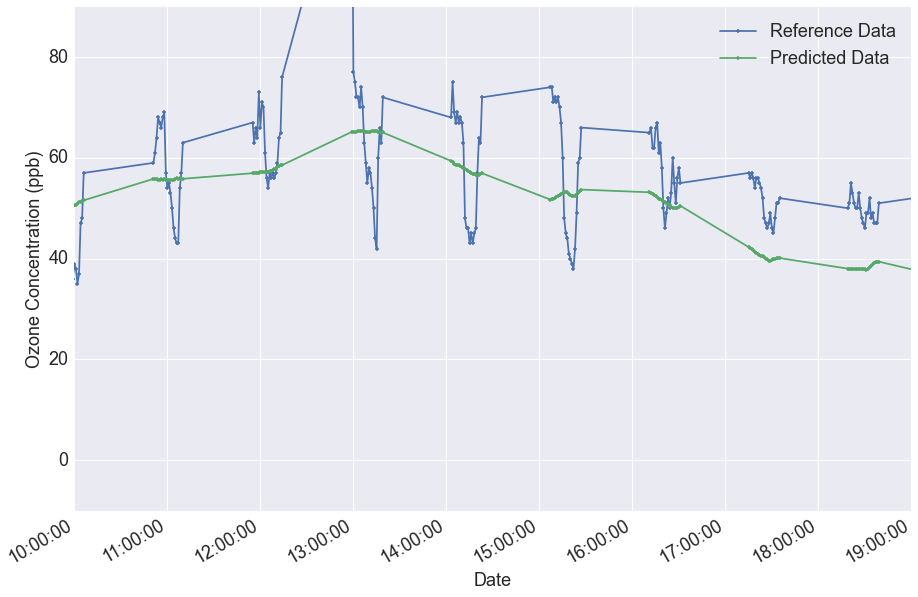

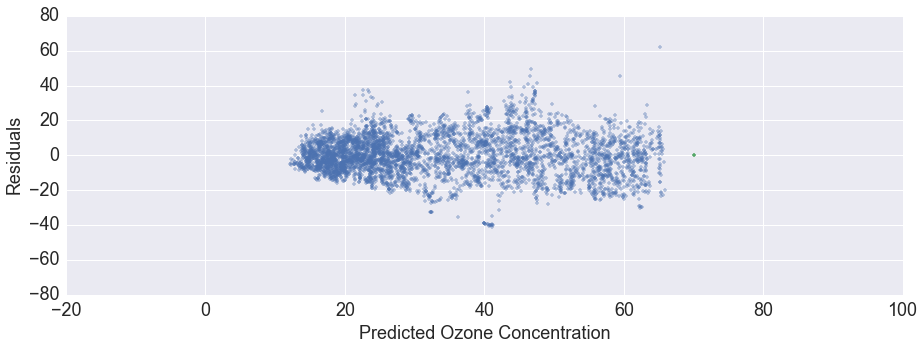

In [168]:
num_good_feat = len(base_features)
fitted_vs_ref_plot(df_cv_lin_base, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_base, ref_column)

#### Linear Regression with All Features.

In [169]:
every_feature = list(df_tr.ix[:,0:len(df_scaled.columns)])
leave_out = ['ref_o3_smooth', 'chunk', 'day', 'O3_ppb', 'UnixTime']
all_features = [f for f in every_feature if f not in leave_out]
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_all, y_cv, df_cv_lin_all, df_H_lin_all = cross_validation_by_day(lin_regr, all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 9.8
Cross-Validation RMSE: 11.0 , High-Value CV RMSE: 14.0 , CV High Diff. in Mean (>50): -10.4
Holdout RMSE: 14.0 , High-Value Holdout RMSE: 14.0 , Holdout High Diff. in Mean.: 2.5


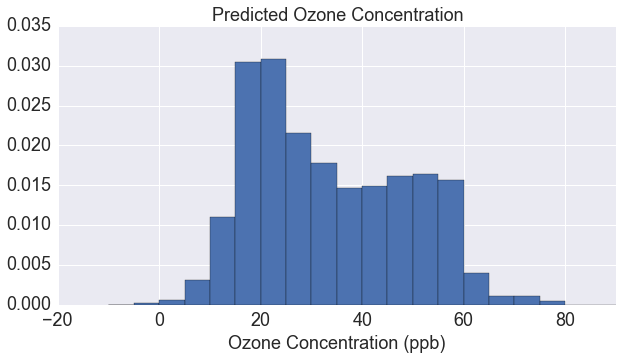

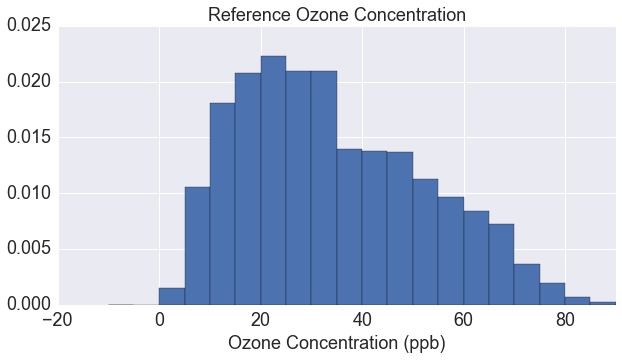

In [170]:
plot_hist(X_pred_cv_all, y_cv, 'Predicted Ozone Concentration')
plot_hist(y_cv, X_pred_cv_all, 'Reference Ozone Concentration')

#### Plot the residuals and comparison curves.

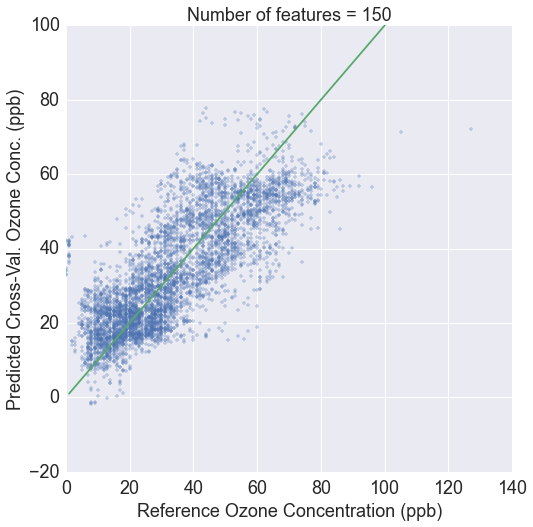

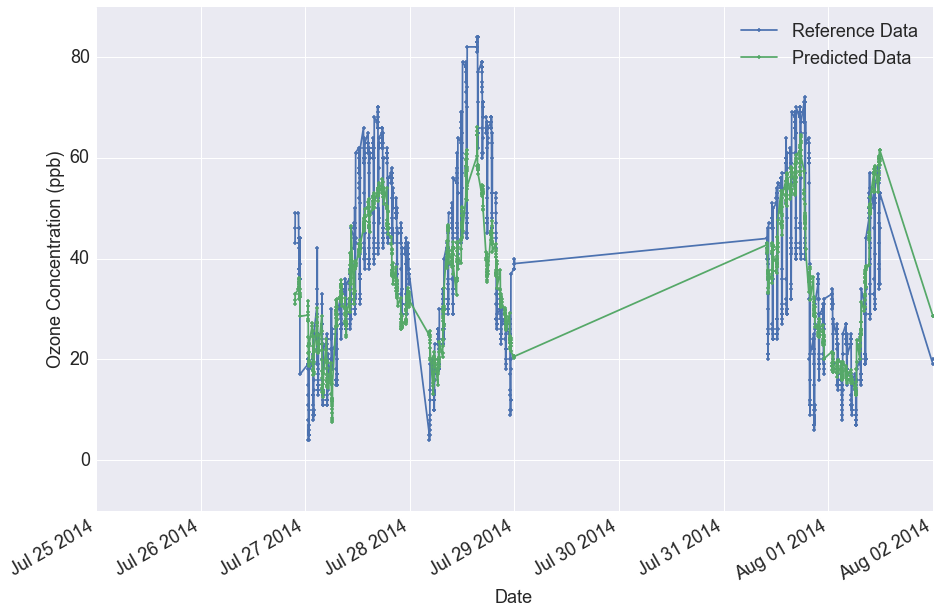

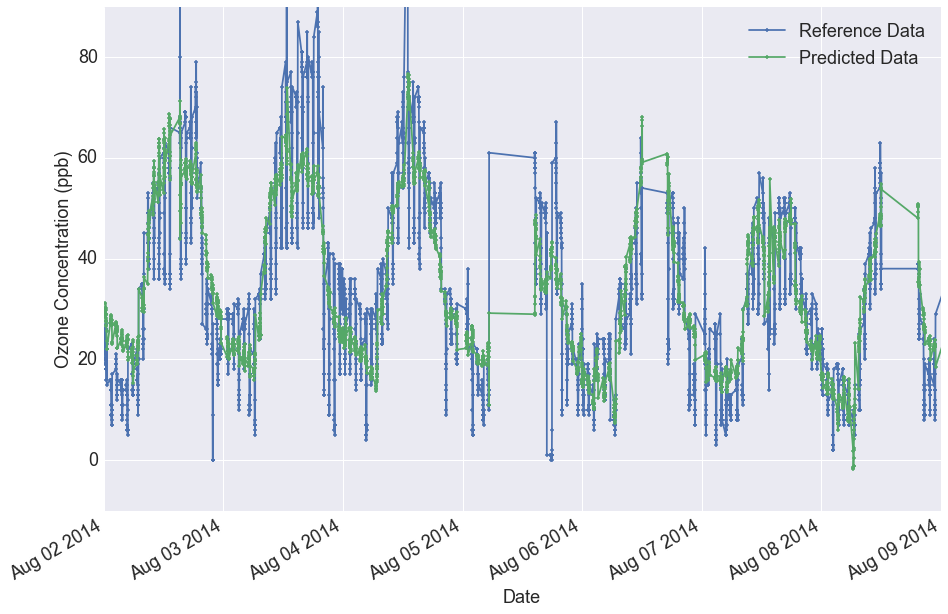

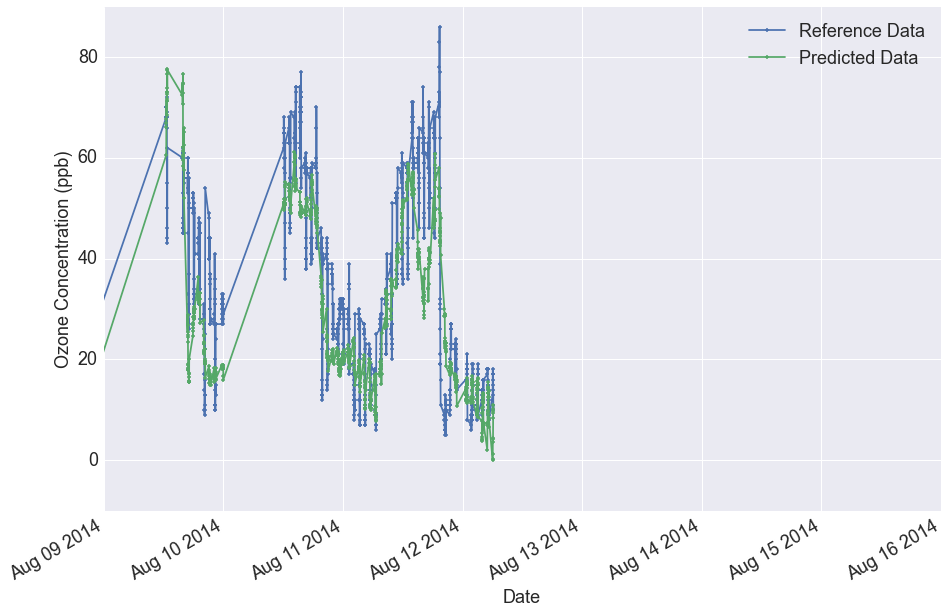

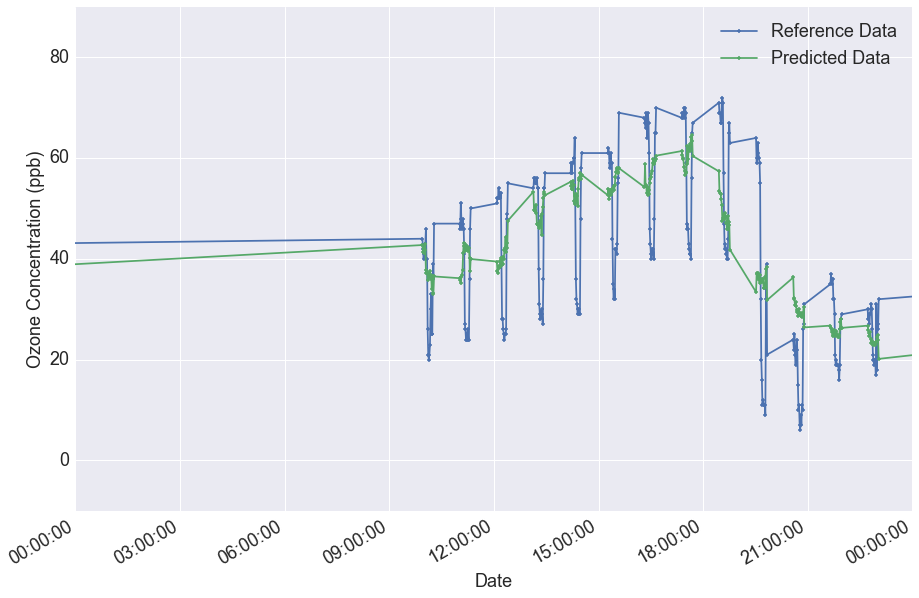

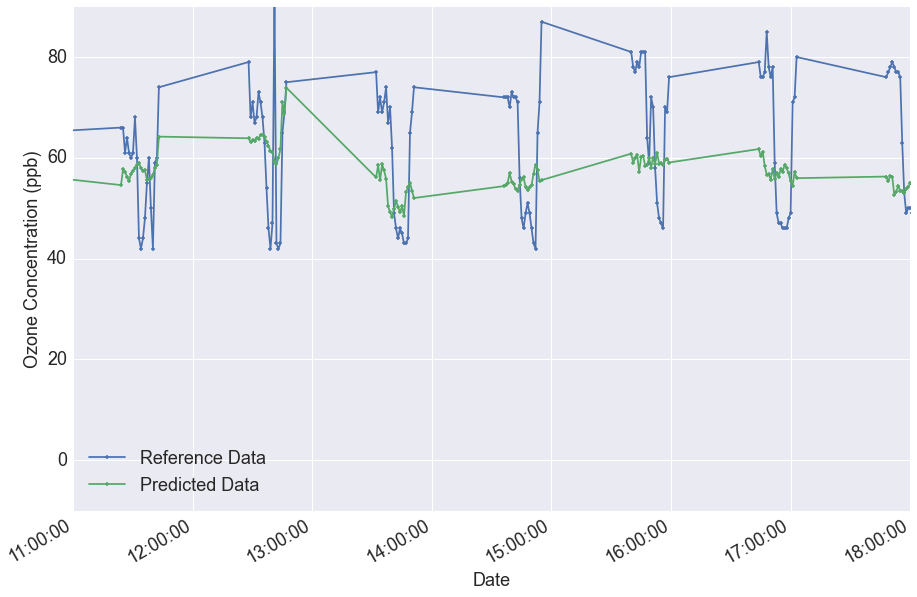

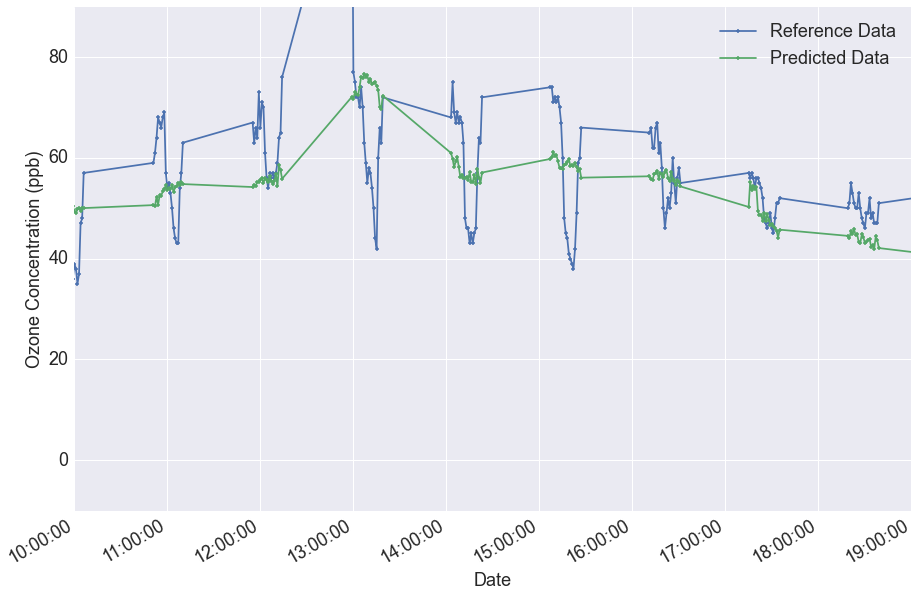

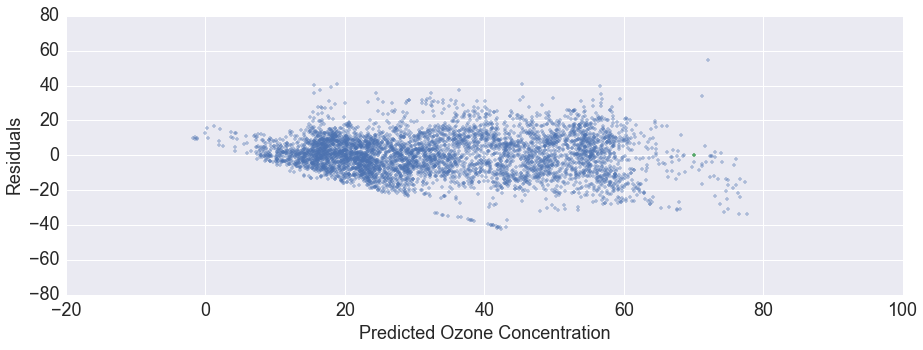

In [171]:
num_good_feat = len(all_features)
fitted_vs_ref_plot(df_cv_lin_all, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_all, ref_column)

## Forward Selection

#### Declare rather you want to use MSE or a custom error function:

In [172]:
#make a list of features from the column titles in the dataframe
features_all = list(df_tr.columns)
leave_out = ['Zenith Angle [degrees]','UnixTime', 'pod_o3_smooth', 'O3_ppb', 'ref_o3_smooth', ref_column, 'chunk']
features = [f for f in features_all if f not in leave_out]
features_it = [f for f in features if f not in 'day']

In [173]:
fs_features, score, RMSE = forward_selection_lodo(lin_regr, features_it, df_tr[[ref_column] + features].dropna(), 'custom_mse', ref_column, days_tr, 15, cust_mse_fact, cutoff_value)

Next best Feature:  ln_O3_int_lag_5 , Score:  12.8 RMSE:  4.6 #: 1
Next best Feature:  e2v03_int_lag_4 , Score:  12.4 RMSE:  3.6 #: 2
Next best Feature:  ln_temp_slope_lag_2 , Score:  12.4 RMSE:  3.8 #: 3
Next best Feature:  ln_temp_slope_lead_2 , Score:  12.3 RMSE:  2.7 #: 4
Next best Feature:  O3_cu , Score:  12.3 RMSE:  3.1 #: 5
Next best Feature:  e2v03_slope_lead_1 , Score:  12.3 RMSE:  5.6 #: 6
Next best Feature:  e2v03_slope_lag_1 , Score:  12.3 RMSE:  8.7 #: 7
Next best Feature:  e2v03_int_lag_1 , Score:  12.3 RMSE:  8.7 #: 8
Next best Feature:  e2v03_int_lead_1 , Score:  12.3 RMSE:  8.7 #: 9
Next best Feature:  ln_O3_int_lag_1 , Score:  12.3 RMSE:  8.7 #: 10
Next best Feature:  ln_O3_int_lead_1 , Score:  12.3 RMSE:  8.7 #: 11
Next best Feature:  Temp_int_lag_1 , Score:  12.3 RMSE:  8.7 #: 12
Next best Feature:  Temp_int_lead_1 , Score:  12.3 RMSE:  8.7 #: 13
Next best Feature:  ln_temp_int_lag_1 , Score:  12.3 RMSE:  8.7 #: 14
Next best Feature:  ln_temp_int_lead_1 , Score:  1

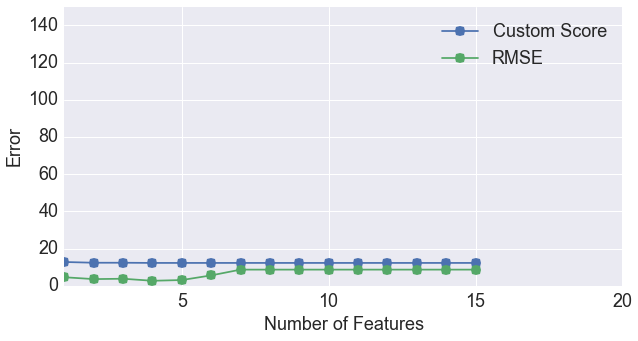

In [175]:
plot_error_vs_features(score, RMSE, [0,150], [1,20])

#### Check Residuals

#### Plot cross-validation fitted data versus reference data, and choose number of features.

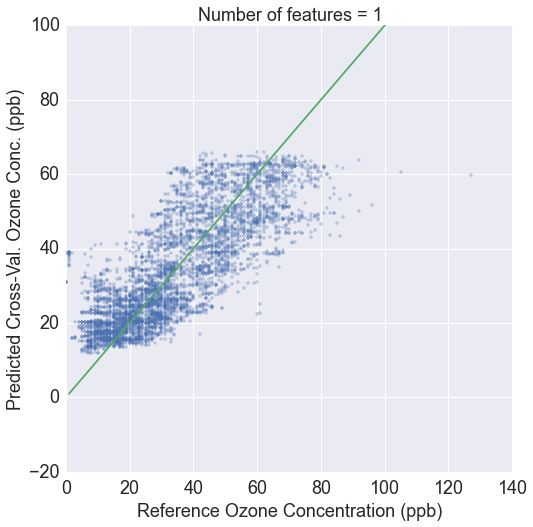

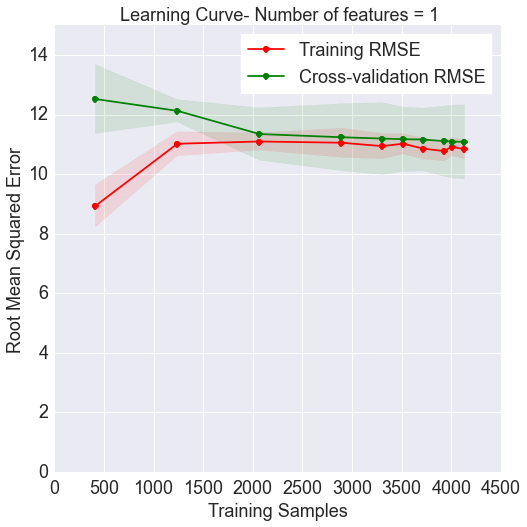

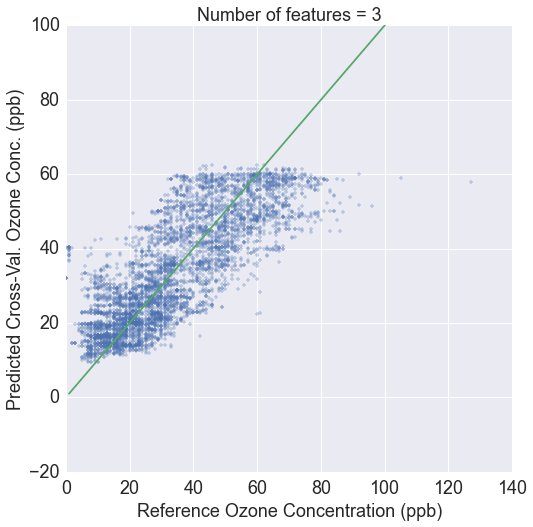

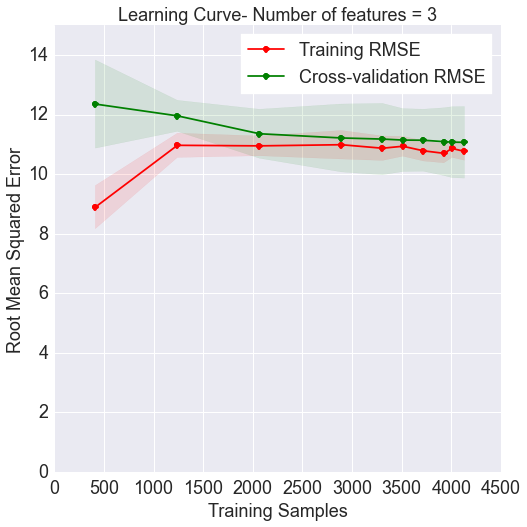

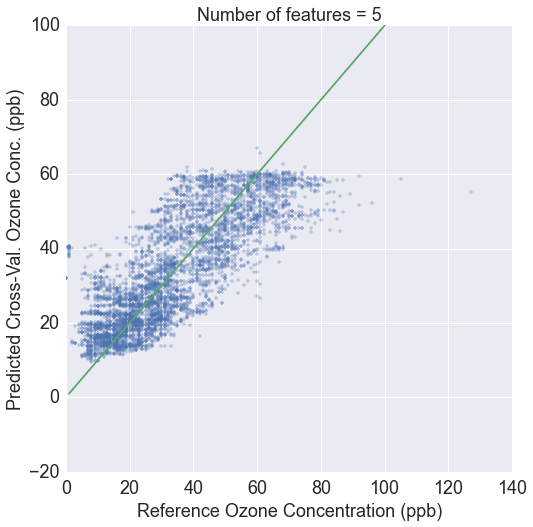

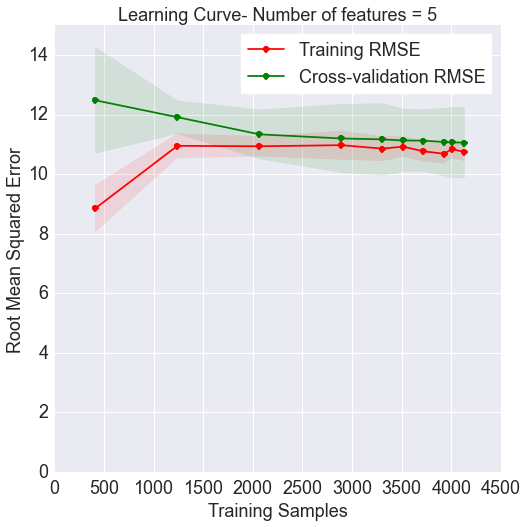

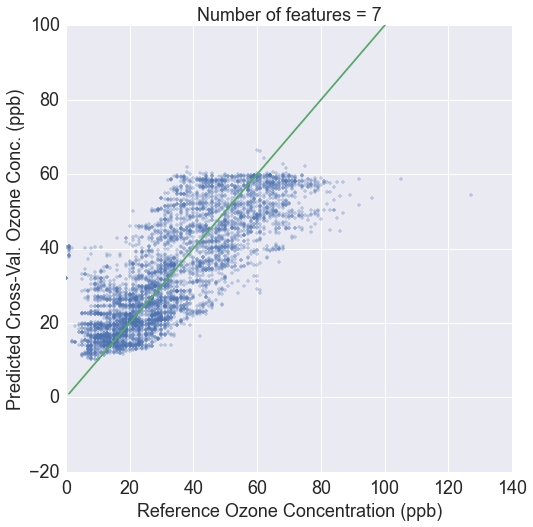

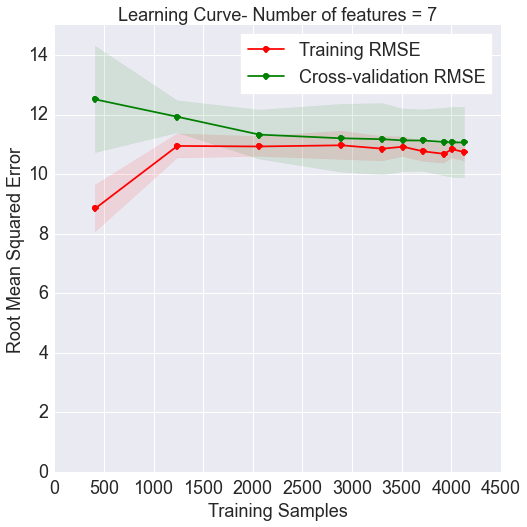

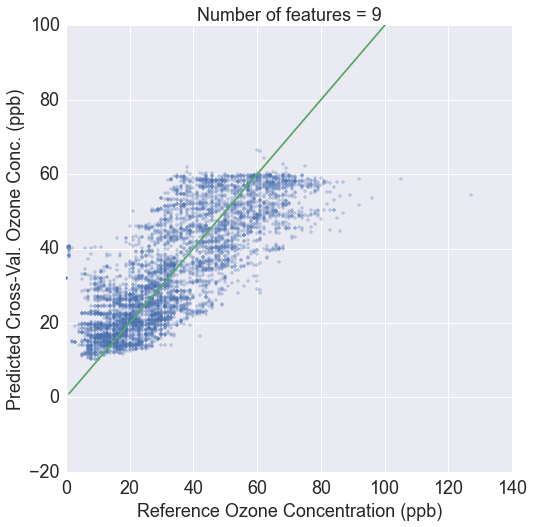

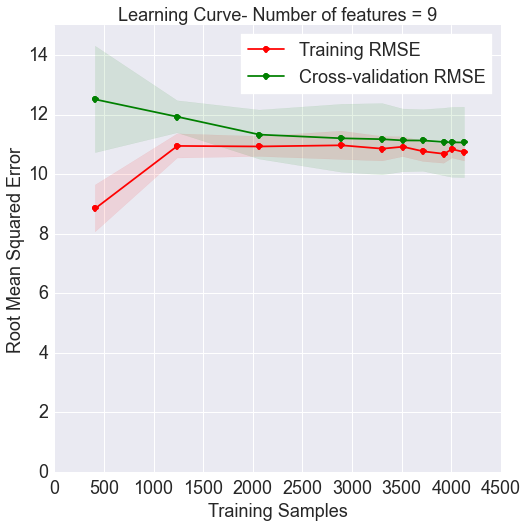

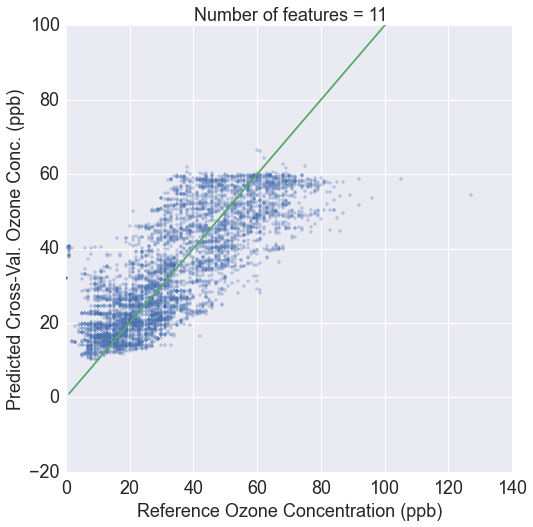

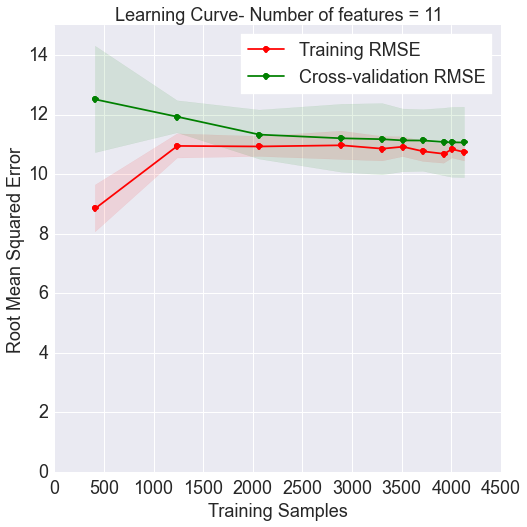

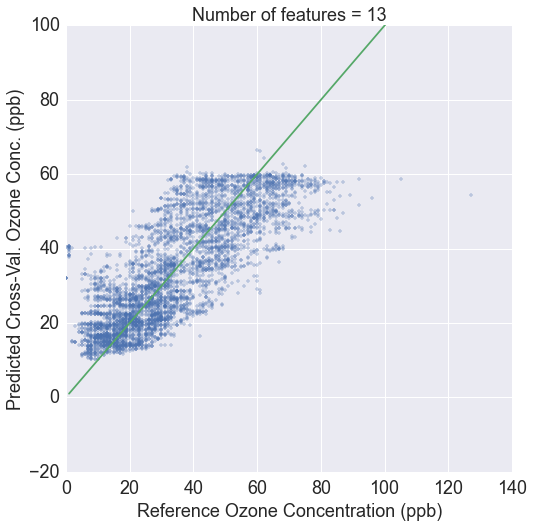

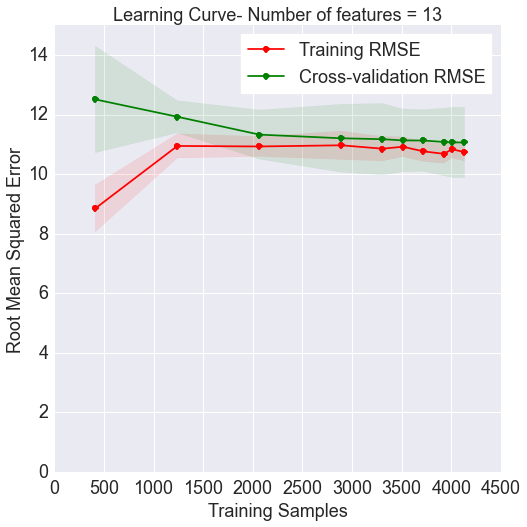

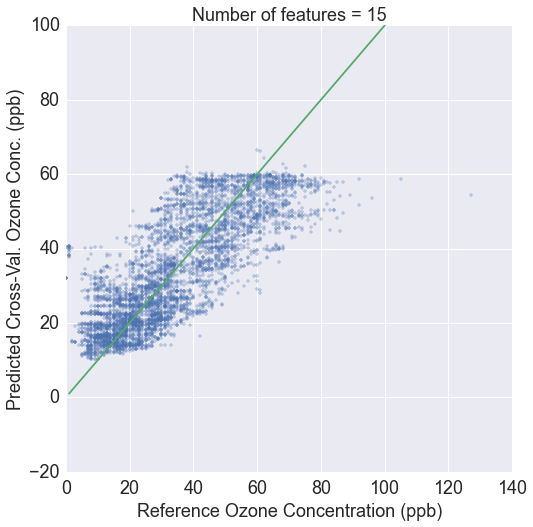

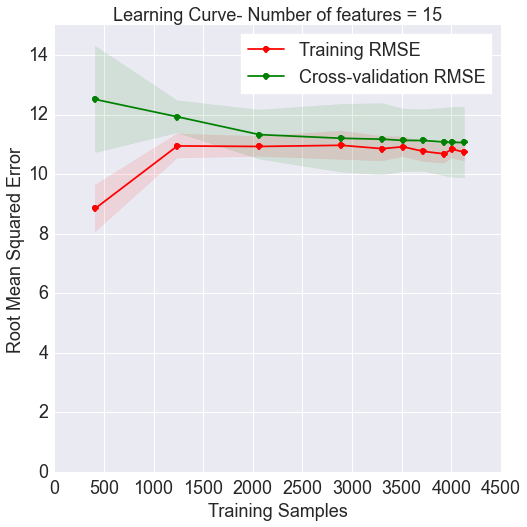

In [176]:
i = 1
while i < 17:
    num_good_feat = i
    df_cv_1, df_H_1 = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
    fitted_vs_ref_plot(df_cv_1, i, ref_column) 
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,15), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 2

#### Enter the chosen number of features, and perform a linear regression.

In [177]:
num_good_feat = 8
best_features = fs_features[:num_good_feat]
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_best, y_cv_best, df_cv_lin_best, df_H_lin_best = cross_validation_by_day(lin_regr, best_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 10.8
Cross-Validation RMSE: 11.0 , High-Value CV RMSE: 13.0 , CV High Diff. in Mean (>50): -10.1
Holdout RMSE: 9.0 , High-Value Holdout RMSE: 7.0 , Holdout High Diff. in Mean.: -5.4


#### Find the beginning of each run.

In [178]:
def find_avg_open_and_close(df):
    start_time = []
    open_avg = []
    closed_avg = []
    flux = []
    count = 0
    for row in range(1,len(df)):
        if (df.index[row] - df.index[row-1]) > pd.Timedelta(minutes=3):
            start_time.append(df.index[row])
            open_avg.append(round(df.O3_fit[row:row+7].mean(), 1))
            closed_avg.append(round(df.O3_fit[row+13:row+16].mean(), 1))
            flux.append(-(0.0015/0.1574)*(open_avg[count]-closed_avg[count])*584.6529/(298))
            count += 1
    return open_avg, closed_avg, flux, start_time

#### Print Best Features

In [179]:
best_features

['ln_O3_int_lag_5',
 'e2v03_int_lag_4',
 'ln_temp_slope_lag_2',
 'ln_temp_slope_lead_2',
 'O3_cu',
 'e2v03_slope_lead_1',
 'e2v03_slope_lag_1',
 'e2v03_int_lag_1']

### Plot the cross-validation data and residuals below.

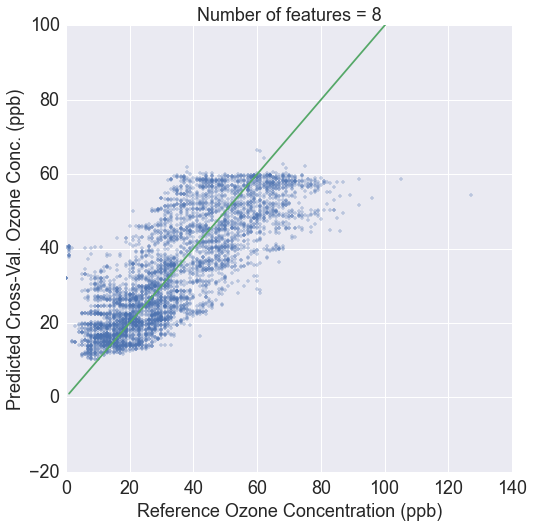

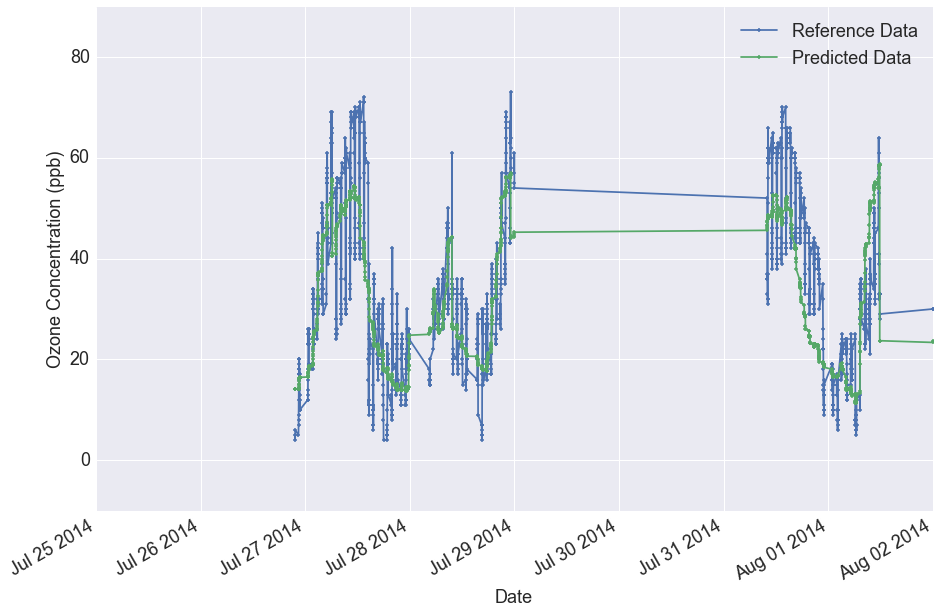

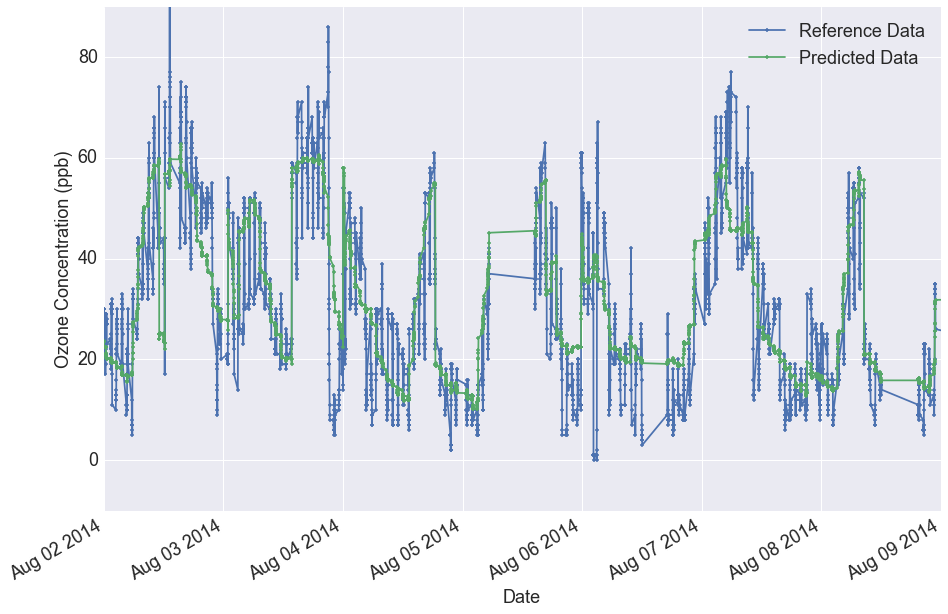

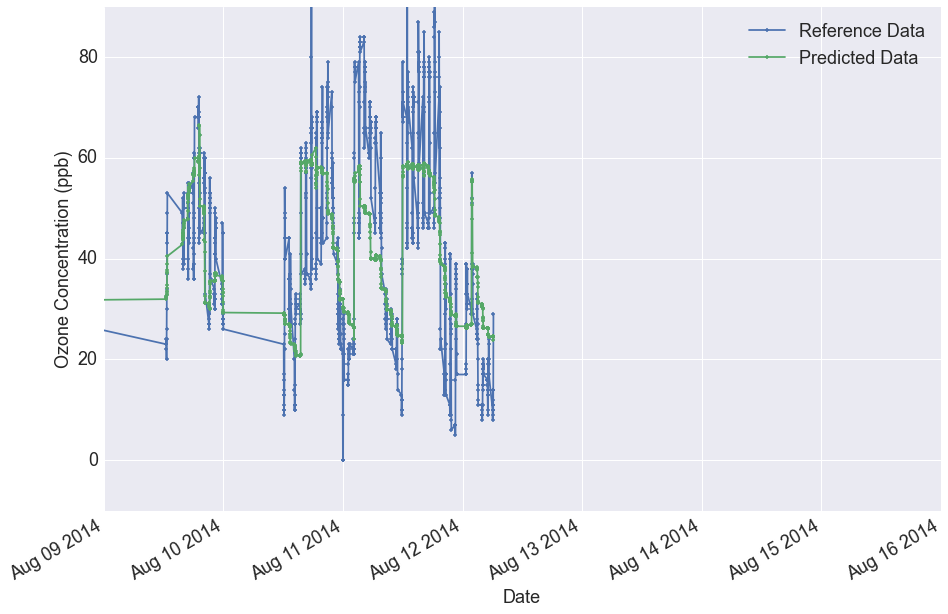

In [180]:
df_lin_regr_best_feat_cv, df_lin_regr_best_feat_H  = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat_cv, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 3, ref_column)

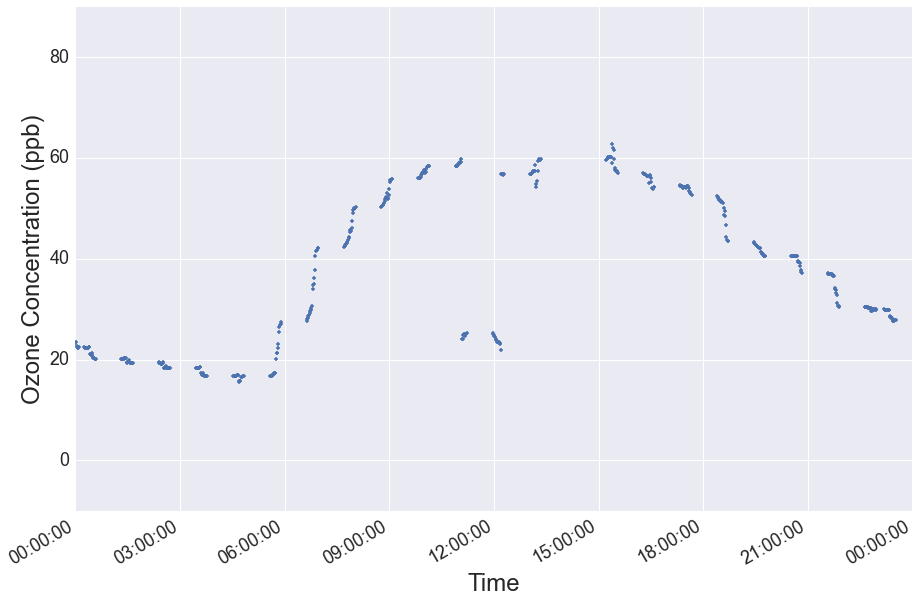

In [183]:
plot_fitted_vs_time_no_lines(df_lin_regr_best_feat_cv, pod_number, 4, ref_column)
plt.savefig('open_and_close.pdf')

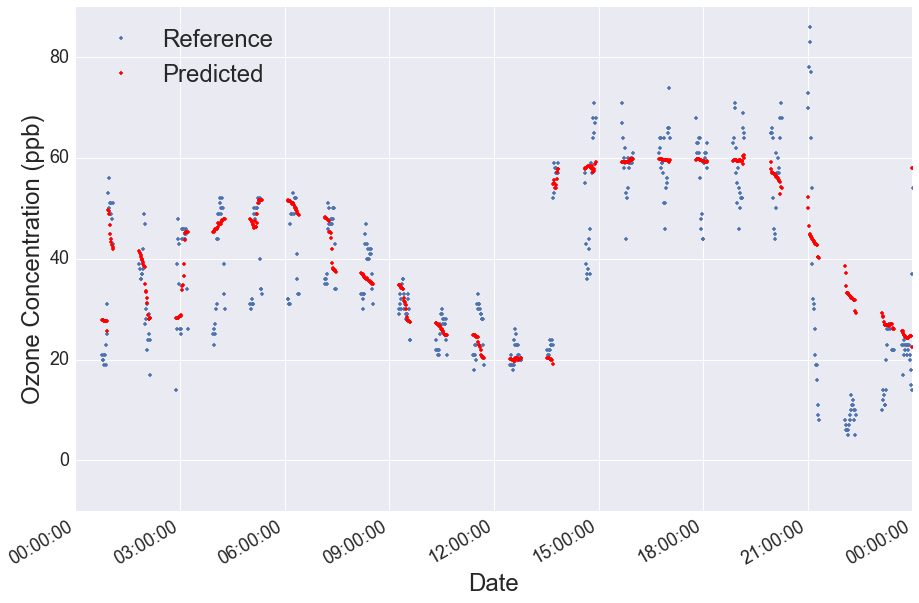

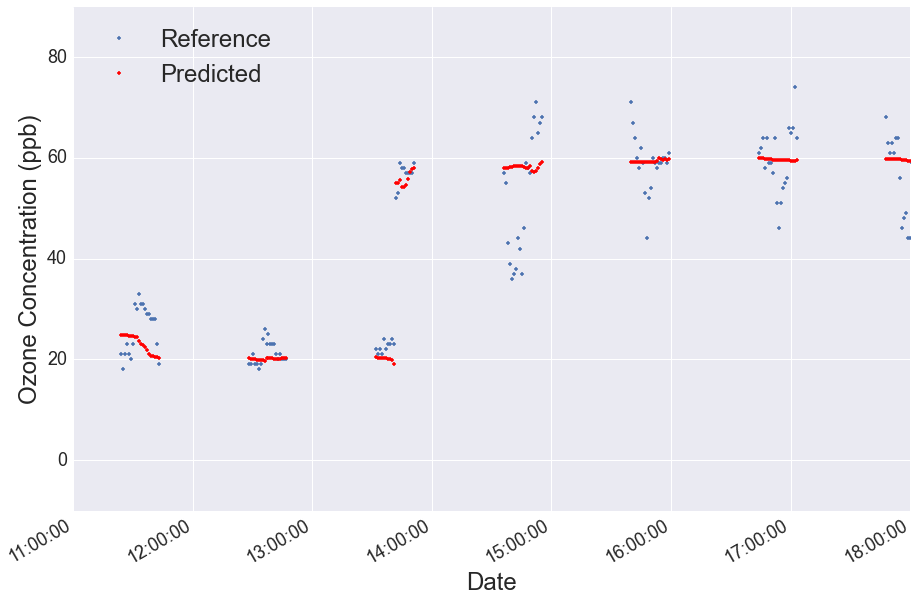

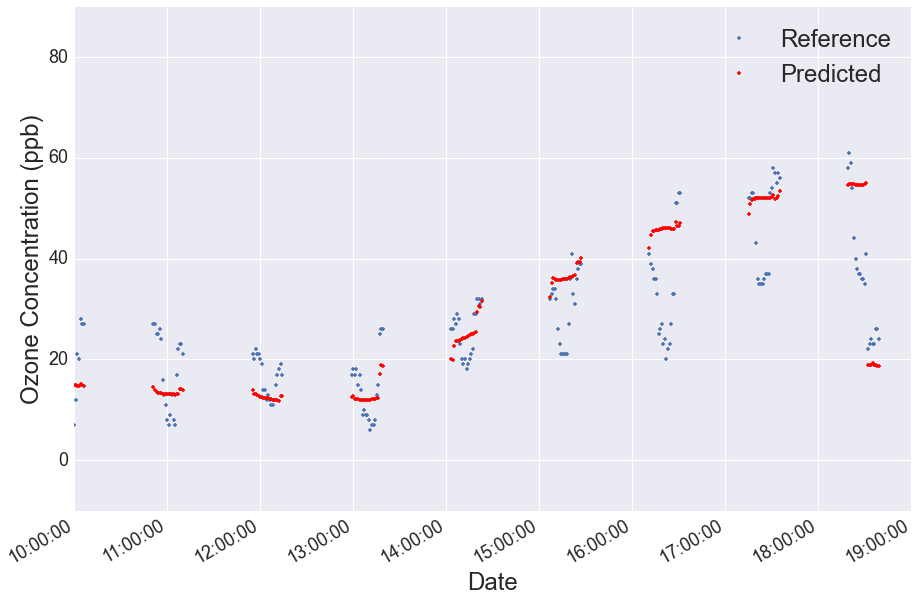

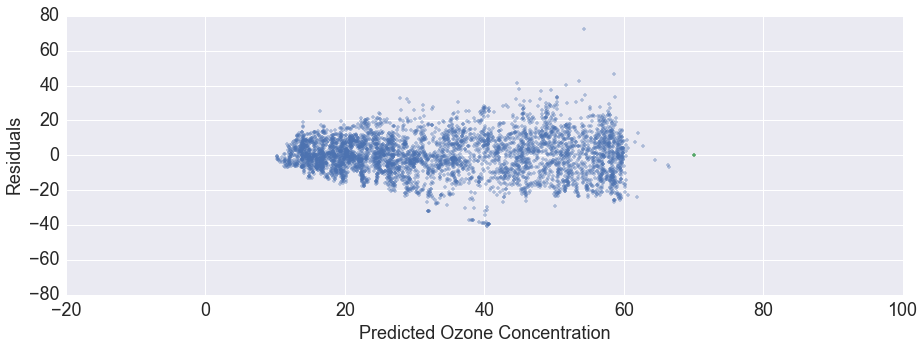

In [189]:
plot_fitted_and_ref_vs_time_no_lines(df_lin_regr_best_feat_cv, pod_number, 4, ref_column)
plt.savefig('open_and_close.pdf')
plot_fitted_and_ref_vs_time_no_lines(df_lin_regr_best_feat_cv, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time_no_lines(df_lin_regr_best_feat_cv, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_lin_regr_best_feat_cv, ref_column)

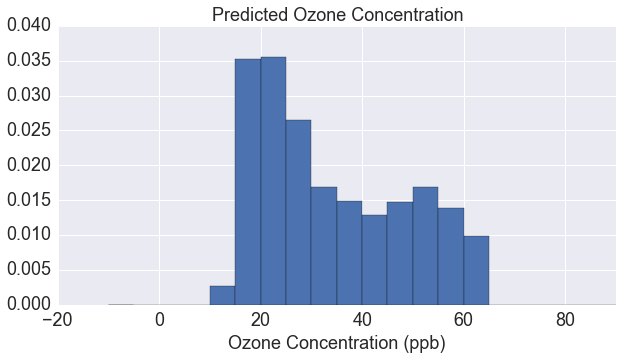

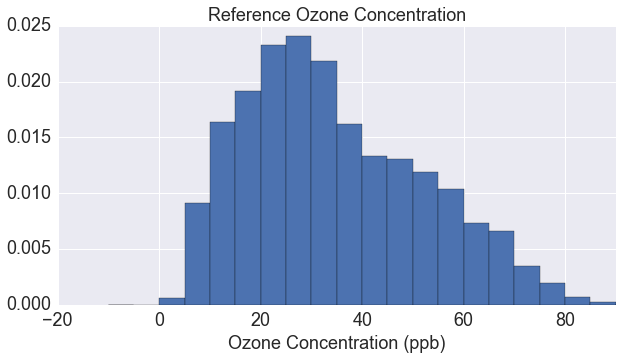

In [61]:
plot_hist(X_pred_cv_best, y_cv_best, 'Predicted Ozone Concentration')
plot_hist(y_cv_best, X_pred_cv_best, 'Reference Ozone Concentration')

## Ridge Regression- All Features

In [62]:
fs_features = all_features
num_good_feat_ridge = len(all_features)

In [63]:
#define the training data
df_fits = df_tr[fs_features[:num_good_feat_ridge] + [ref_column] + ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat_ridge]].values
y = df_scaled[ref_column].values

#### Find the best lambda value using cross-validation

In [64]:
best_lambda_ridge, lambda_ridge, coefs, mean_score_lambda = find_best_lambda(Ridge, fs_features[:num_good_feat_ridge], df_fits, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.0000001, 1000000, 3, cust_mse_fact, cutoff_value)

lambda: 1e-07
score: 23.99
lambda: 3e-07
score: 23.99
lambda: 9e-07
score: 23.86
lambda: 2.7e-06
score: 23.59
lambda: 8.1e-06
score: 23.36
lambda: 2.43e-05
score: 23.25
lambda: 7.29e-05
score: 23.19
lambda: 0.0002187
score: 23.11
lambda: 0.0006561
score: 23.02
lambda: 0.0019683
score: 22.99
lambda: 0.0059049
score: 22.99
lambda: 0.0177147
score: 22.97
lambda: 0.0531441
score: 22.76
lambda: 0.1594323
score: 22.59
lambda: 0.4782969
score: 22.48
lambda: 1.4348907
score: 22.38
lambda: 4.3046721
score: 22.36
lambda: 12.9140163
score: 22.45
lambda: 38.7420489
score: 22.6
lambda: 116.2261467
score: 22.63
lambda: 348.6784401
score: 22.6
lambda: 1046.0353203
score: 22.68
lambda: 3138.1059609
score: 22.83
lambda: 9414.3178827
score: 23.47
lambda: 28242.9536481
score: 24.76
lambda: 84728.8609443
score: 27.98
lambda: 254186.582833
score: 34.25
lambda: 762559.748499
score: 41.97
Best Lambda: 4.3046721


#### Plot the values of lambda versus the coefficients and the custom score. 

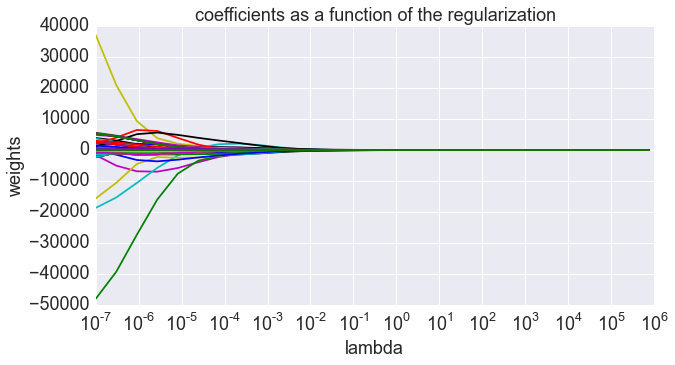

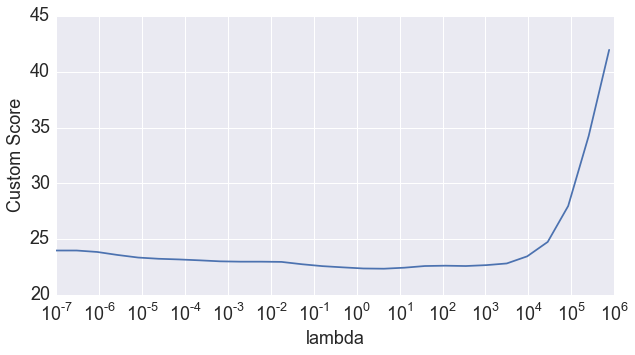

In [65]:
plot_lambda(lambda_ridge, coefs, mean_score_lambda)

#### Use the best lambda value found above to find errors.

In [66]:
MSE_CV_ridge, MSE_T_ridge, MSE_H_ridge, high_MSE_cv_ridge, X_pred_cv_ridge, y_cv_ridge, df_cv_ridge, df_H_ridge = cross_validation_by_day(Ridge(alpha = best_lambda_ridge), all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 10.0
Cross-Validation RMSE: 11.0 , High-Value CV RMSE: 15.0 , CV High Diff. in Mean (>50): -9.8
Holdout RMSE: 12.0 , High-Value Holdout RMSE: 16.0 , Holdout High Diff. in Mean.: -14.1


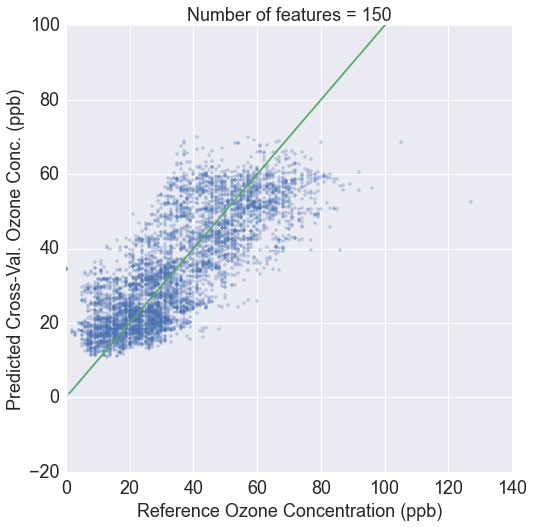

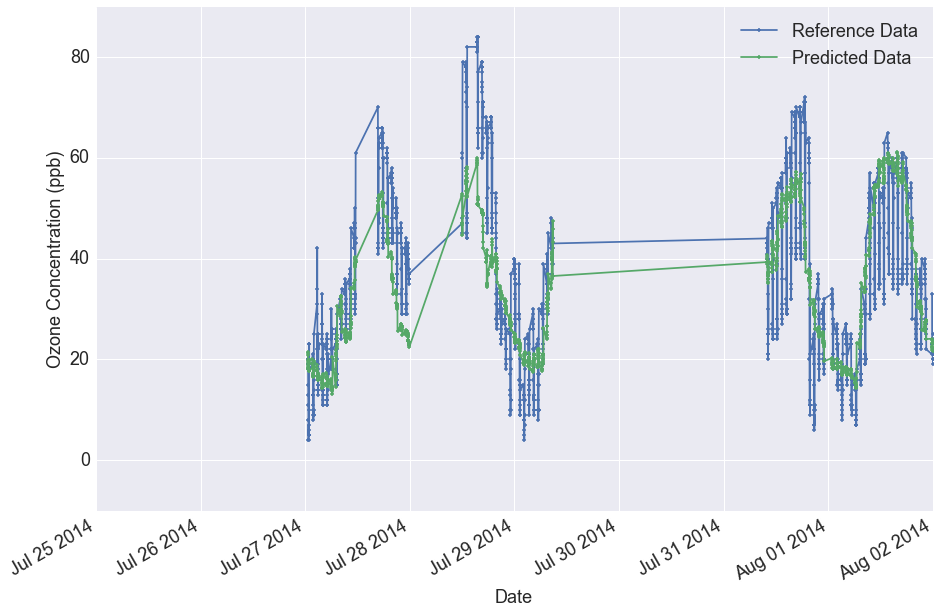

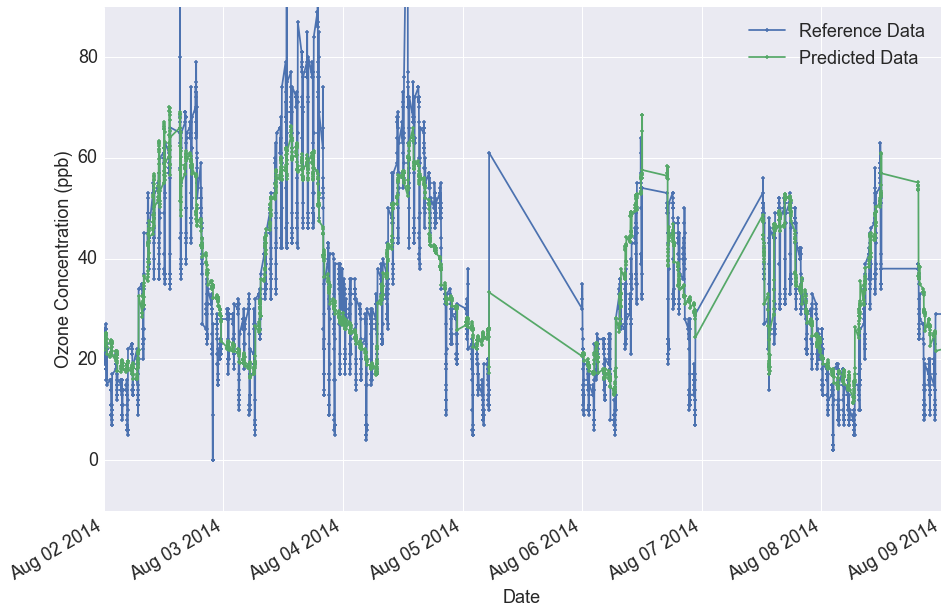

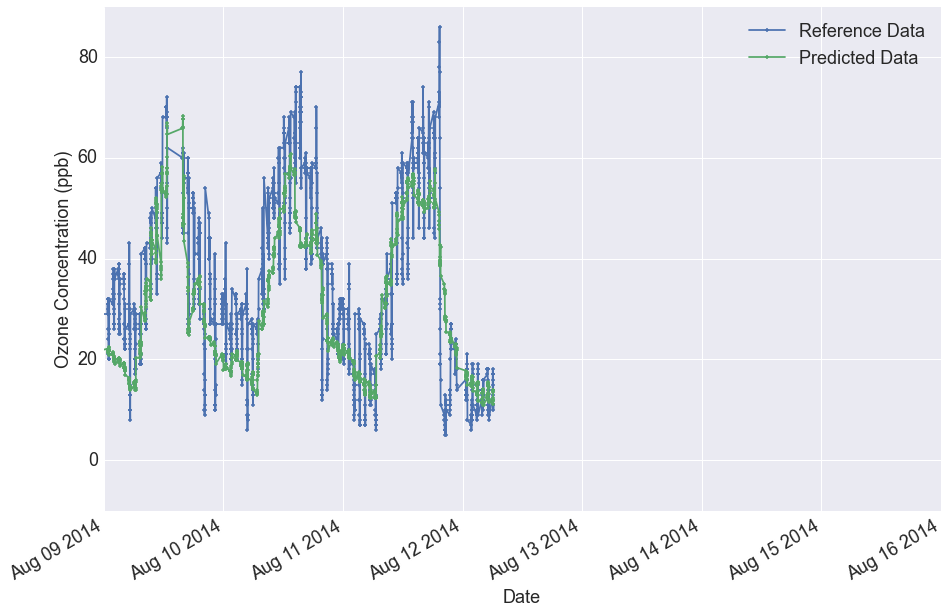

In [117]:
fitted_vs_ref_plot(df_cv_ridge, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 3, ref_column)

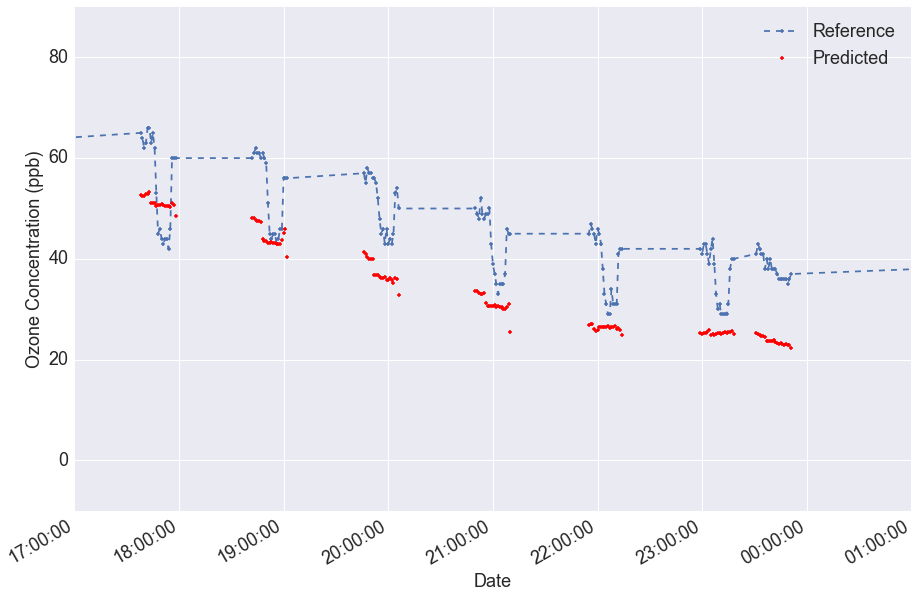

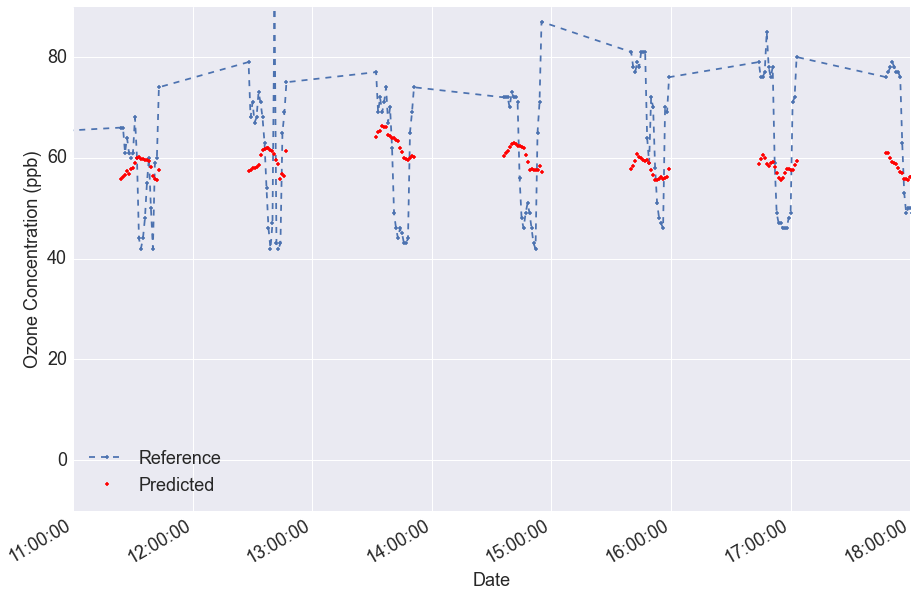

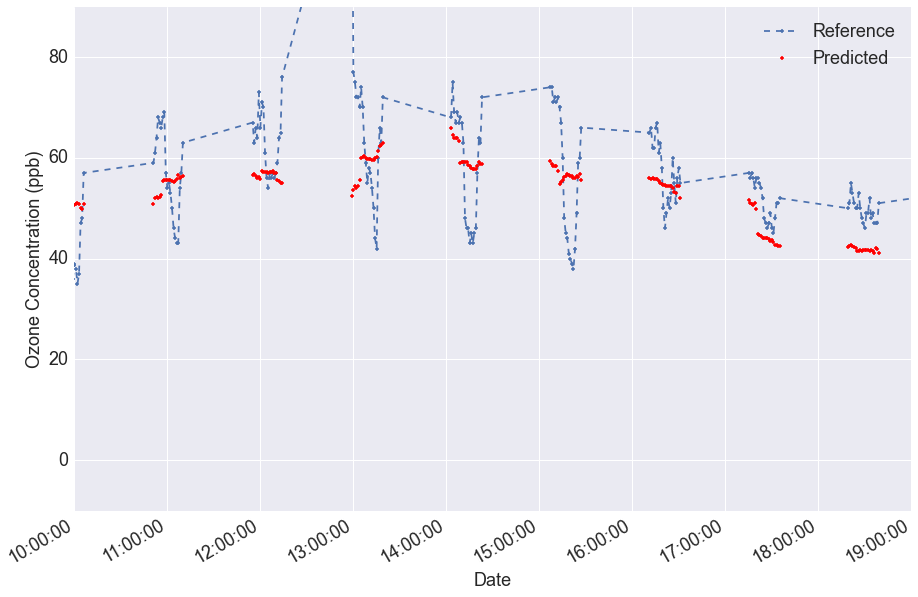

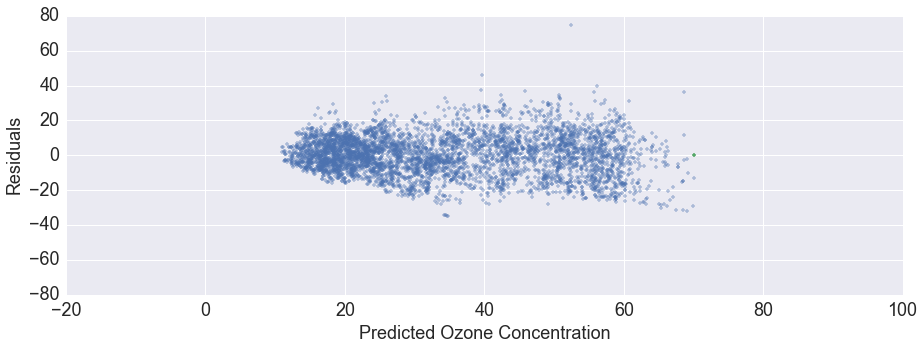

## Lasso- All Features

In [73]:
best_lambda_lasso, lambda_lasso, coefs_lasso, mean_score_lambda_lasso = find_best_lambda(Lasso, fs_features[:num_good_feat_ridge], df_fits, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.000001, 100, 3, cust_mse_fact, cutoff_value)

lambda: 1e-06
score: 22.43
lambda: 3e-06
score: 22.43
lambda: 9e-06
score: 22.43
lambda: 2.7e-05
score: 22.43
lambda: 8.1e-05
score: 22.43
lambda: 0.000243
score: 22.43
lambda: 0.000729
score: 22.44
lambda: 0.002187
score: 22.44
lambda: 0.006561
score: 22.56
lambda: 0.019683
score: 22.88
lambda: 0.059049
score: 23.0
lambda: 0.177147
score: 23.24
lambda: 0.531441
score: 23.69
lambda: 1.594323
score: 25.43
lambda: 4.782969
score: 31.58
lambda: 14.348907
score: 50.86
lambda: 43.046721
score: 51.4
Best Lambda: 1e-06


/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


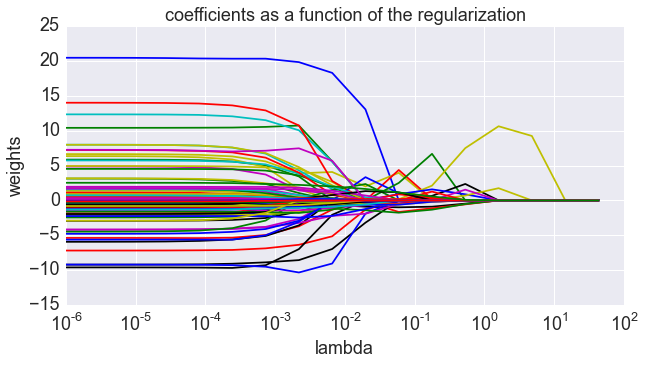

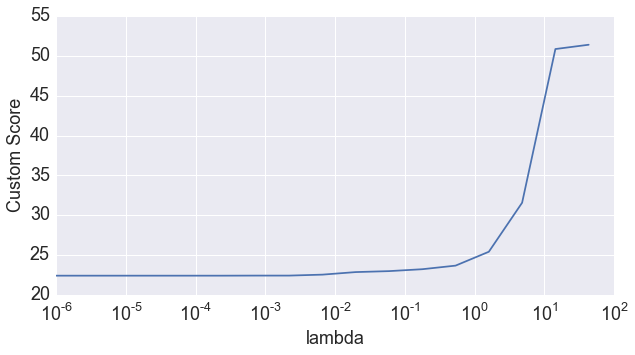

In [74]:
plot_lambda(lambda_lasso, coefs_lasso, mean_score_lambda_lasso)

#### Use the best lambda value found above to find holdout values.

In [75]:
MSE_CV_lasso, MSE_T_lasso, MSE_H_lasso, high_MSE_cv_lasso, X_pred_cv_lasso, y_cv_lasso, df_cv_lasso, df_H_lasso = cross_validation_by_day(Lasso(alpha = best_lambda_lasso), all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 10.0
Cross-Validation RMSE: 11.0 , High-Value CV RMSE: 15.0 , CV High Diff. in Mean (>50): -9.8
Holdout RMSE: 12.0 , High-Value Holdout RMSE: 16.0 , Holdout High Diff. in Mean.: -14.1


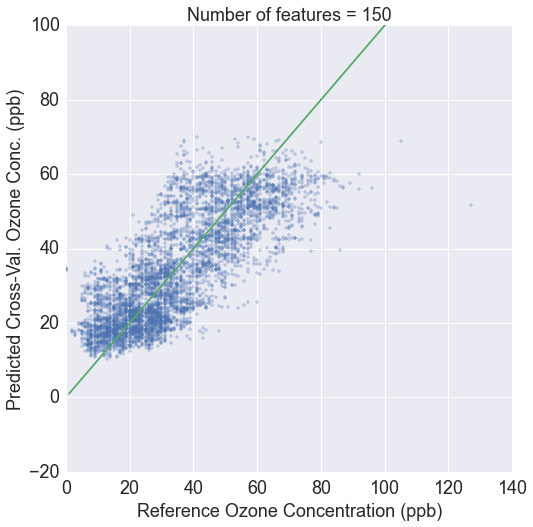

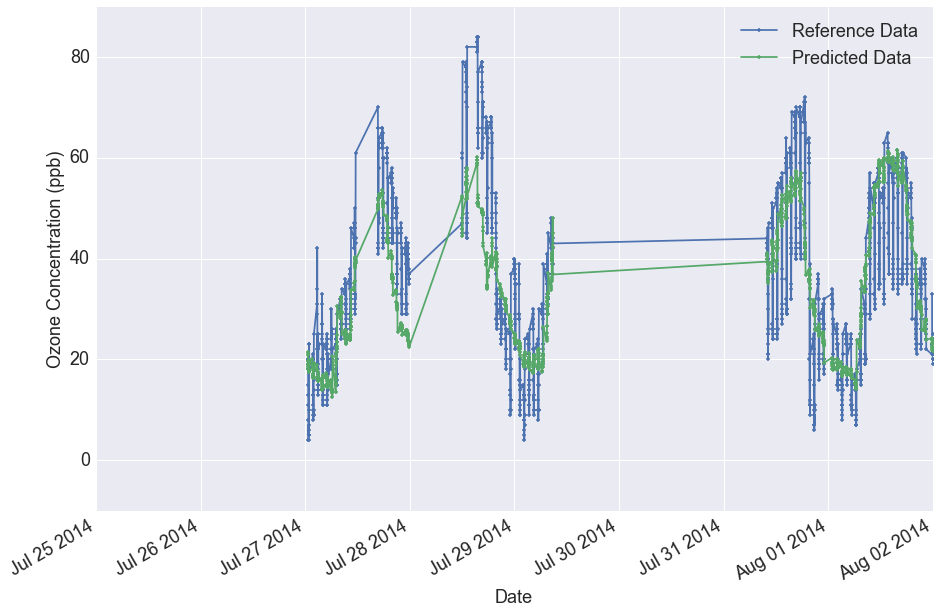

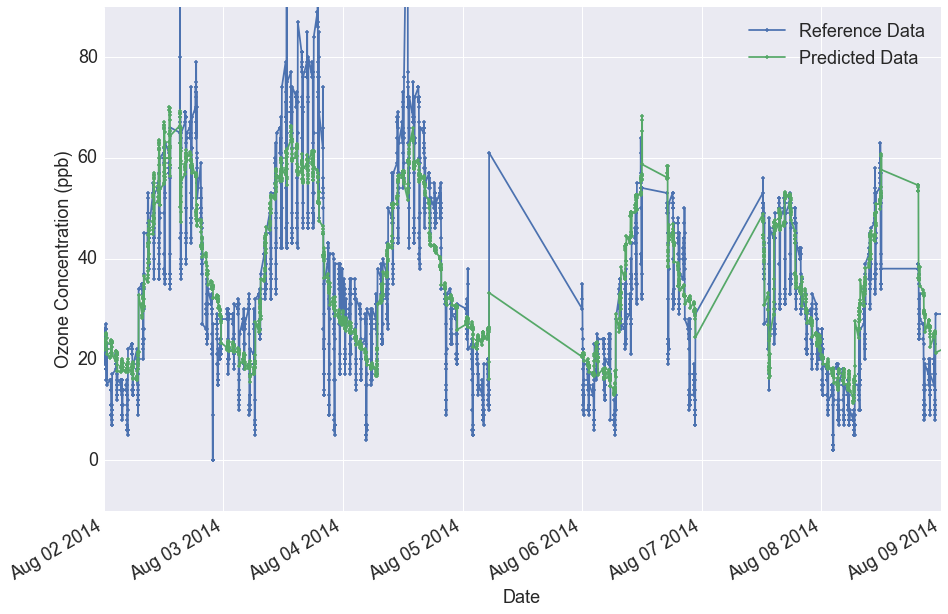

In [115]:
fitted_vs_ref_plot(df_cv_lasso, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 2, ref_column)

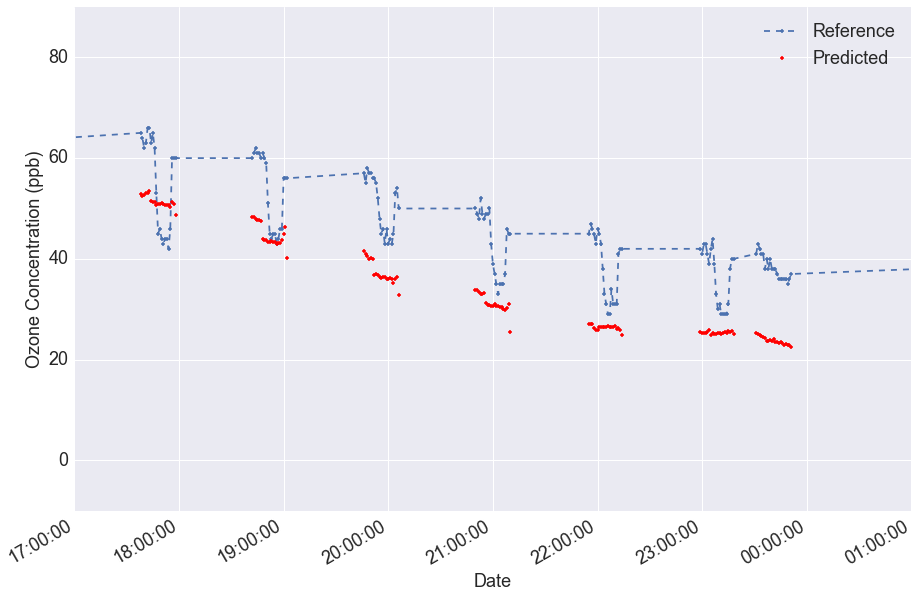

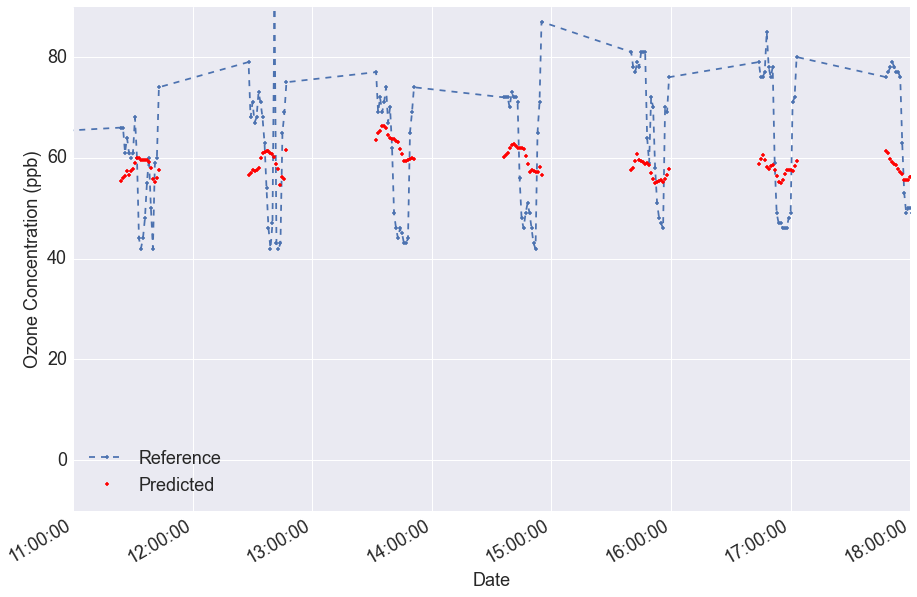

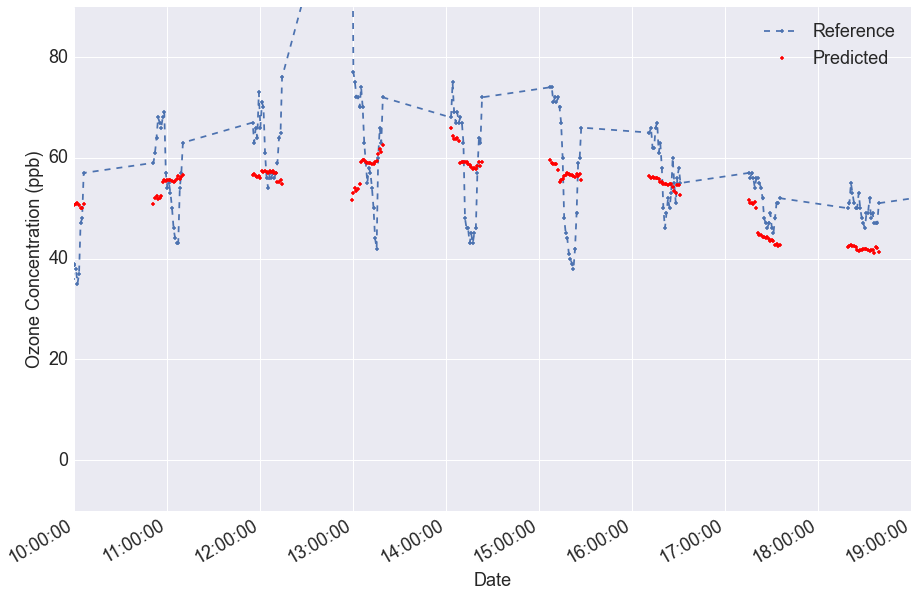

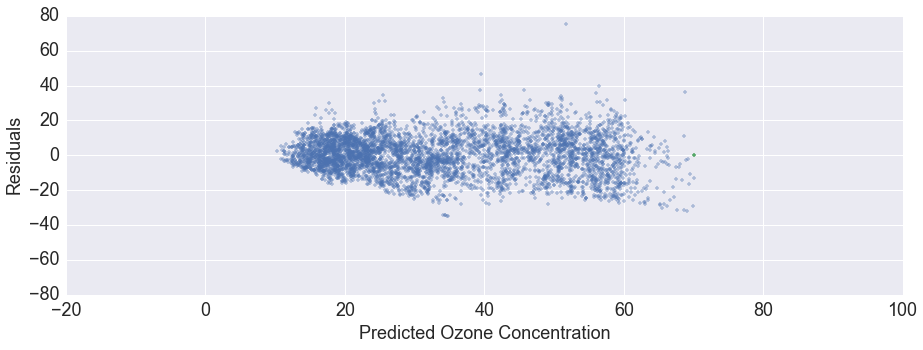

In [116]:
plot_fitted_and_ref_vs_time_no_lines(df_cv_lasso, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time_no_lines(df_cv_lasso, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time_no_lines(df_cv_lasso, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_cv_lasso, ref_column)

## Support Vector Machine- Best Features

In [81]:
RMSE_CV_day, df_svm_fit, df_H_svm = fit_svm_and_find_MSE(best_features, df_tr, days_tr, ref_column, cutoff_value, df_hold, cust_mse_fact)  

7-27
7-28
7-29
7-31
8-1
8-2
8-3
8-4
8-5
8-6
8-7
8-8
8-9
8-10
8-11
8-12
{'epsilon': 1, 'C': 1}
Training RMSE: 3.2
Cross-Validation RMSE: 3.0 , High-Value CV RMSE: 4.0 , CV High Diff. in Mean (>50): -9.2
Holdout RMSE: 12.0 , High-Value Holdout RMSE: 15.0 , Holdout High Diff. in Mean.: -13.2


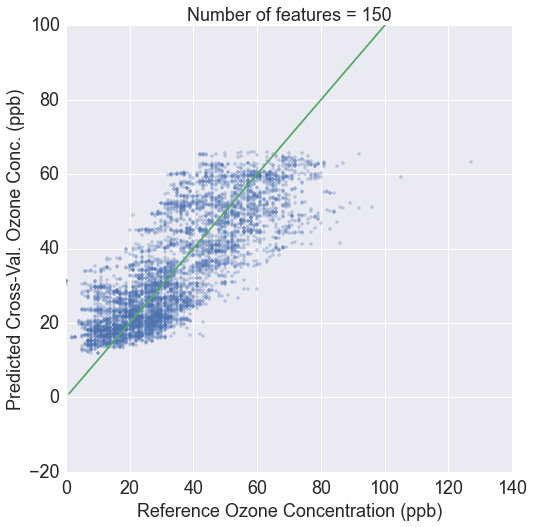

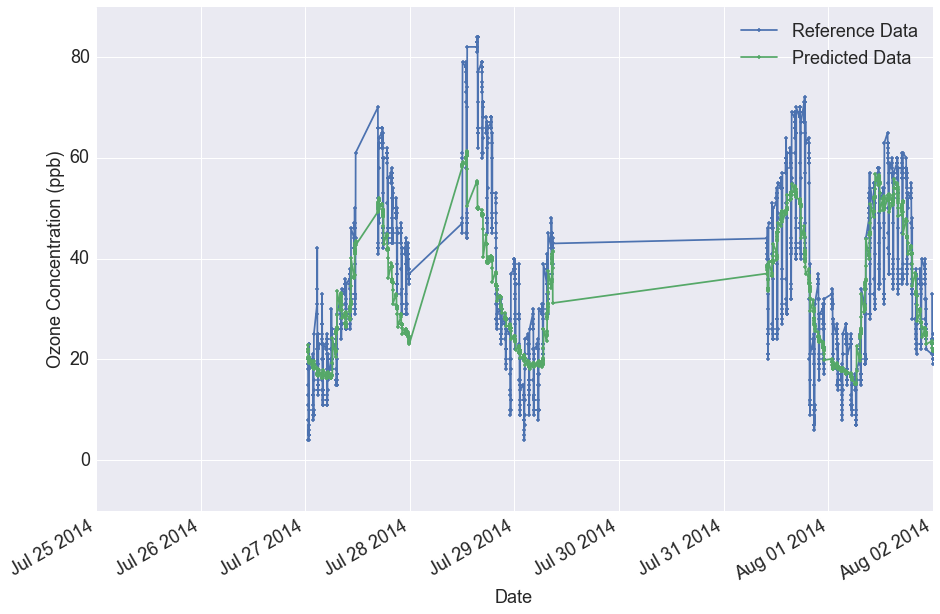

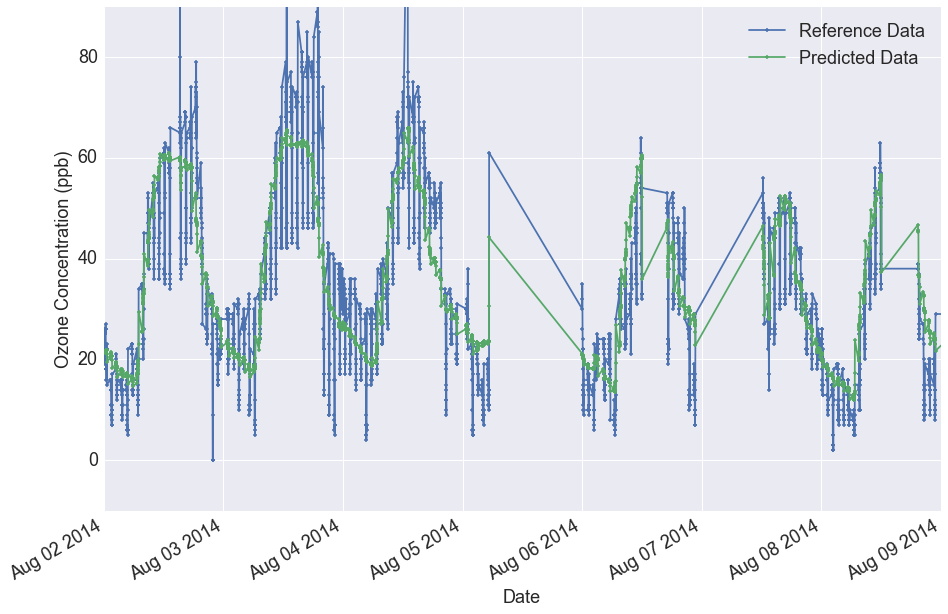

In [112]:
fitted_vs_ref_plot(df_svm_fit, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 2, ref_column)

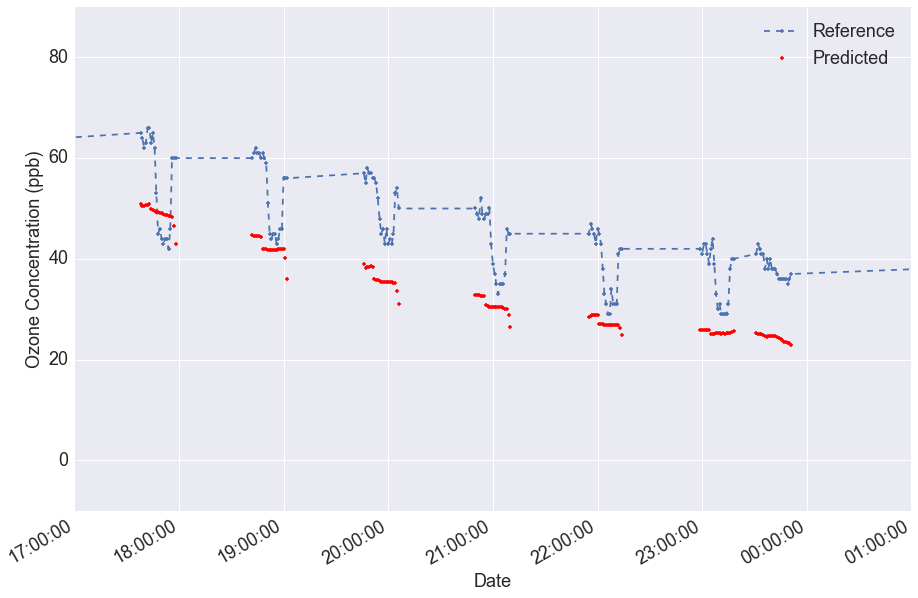

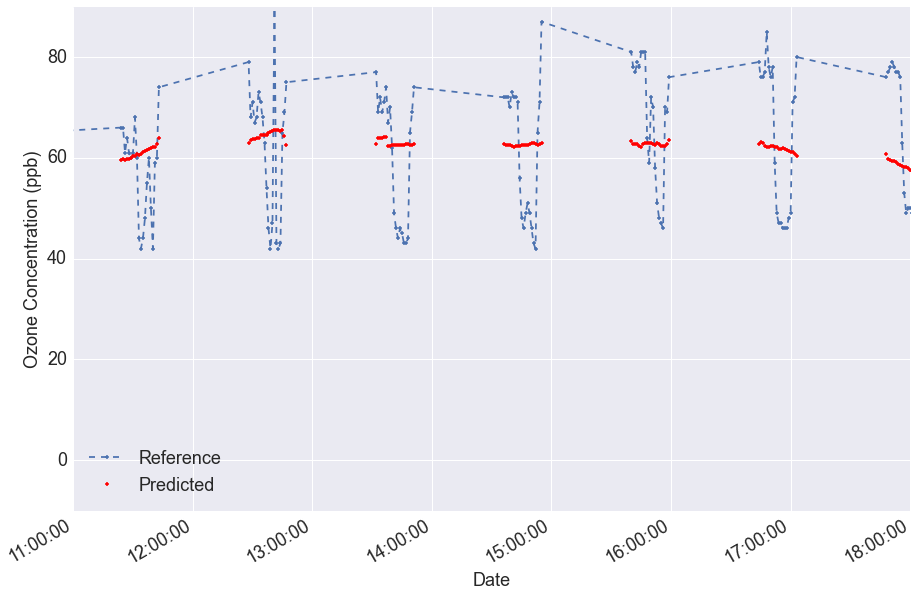

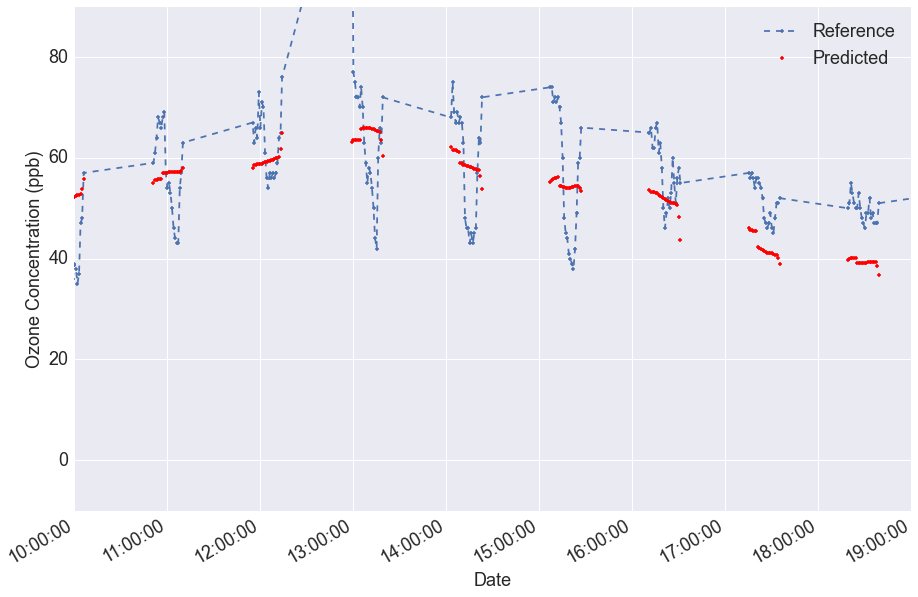

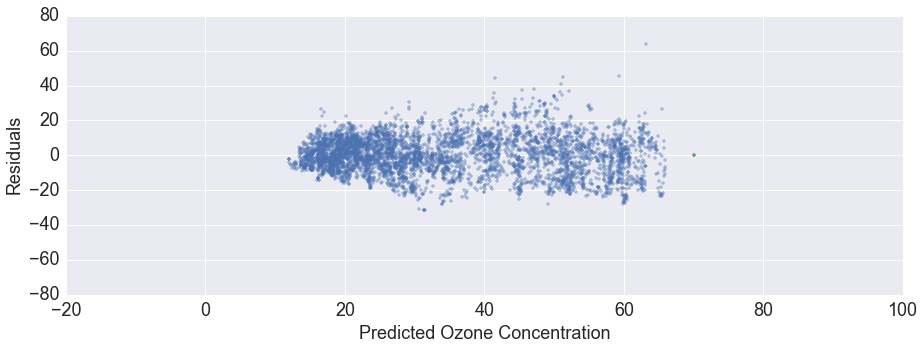

In [114]:
plot_fitted_and_ref_vs_time_no_lines(df_svm_fit, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time_no_lines(df_svm_fit, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time_no_lines(df_svm_fit, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_svm_fit, ref_column)

## Support Vector Machine- All Features

In [83]:
RMSE_CV_day_all, df_svm_fit_all, df_H_svm_all = fit_svm_and_find_MSE(all_features, df_tr, days_tr, ref_column, cutoff_value, df_hold, cust_mse_fact)  

7-27
7-28
7-29
7-31
8-1
8-2
8-3
8-4
8-5
8-6
8-7
8-8
8-9
8-10
8-11
8-12
{'epsilon': 0.1, 'C': 1}
Training RMSE: 3.2
Cross-Validation RMSE: 3.0 , High-Value CV RMSE: 3.0 , CV High Diff. in Mean (>50): -8.1
Holdout RMSE: 12.0 , High-Value Holdout RMSE: 15.0 , Holdout High Diff. in Mean.: -13.4


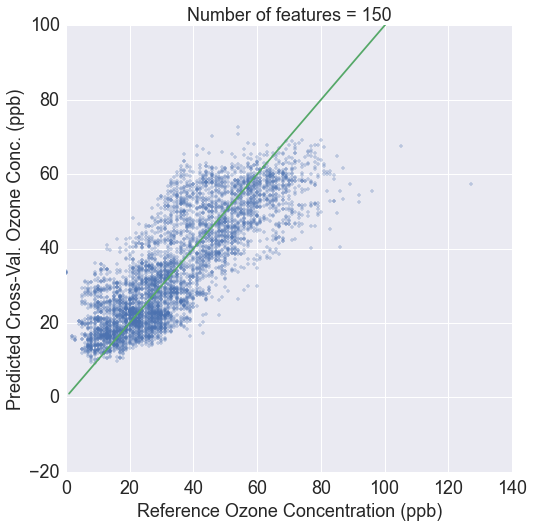

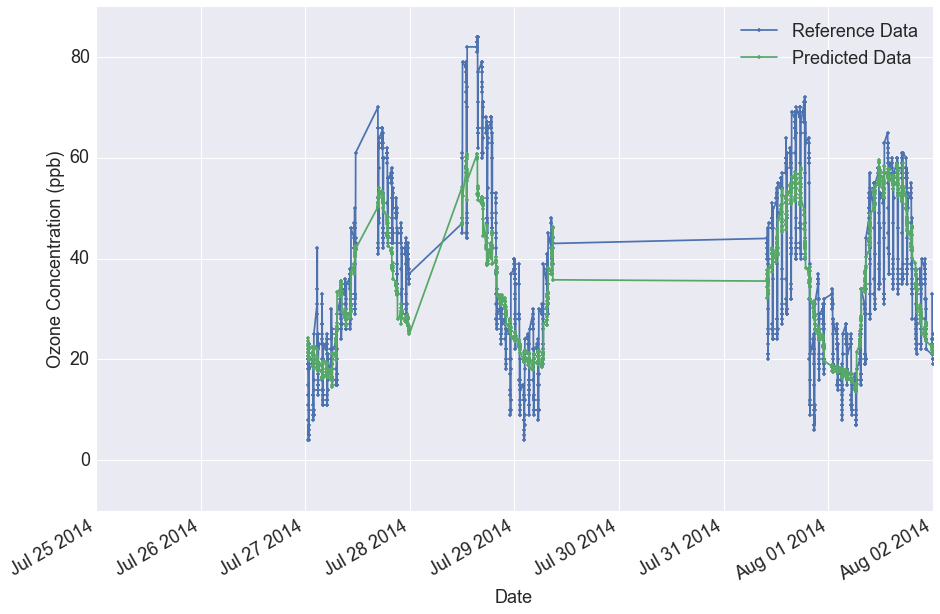

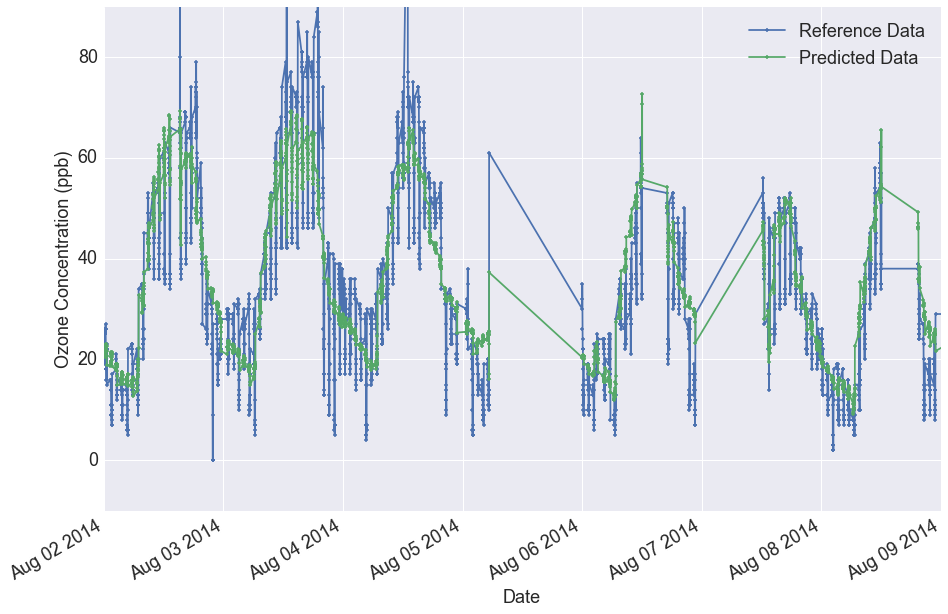

In [110]:
fitted_vs_ref_plot(df_svm_fit_all, len(all_features), ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 2, ref_column)

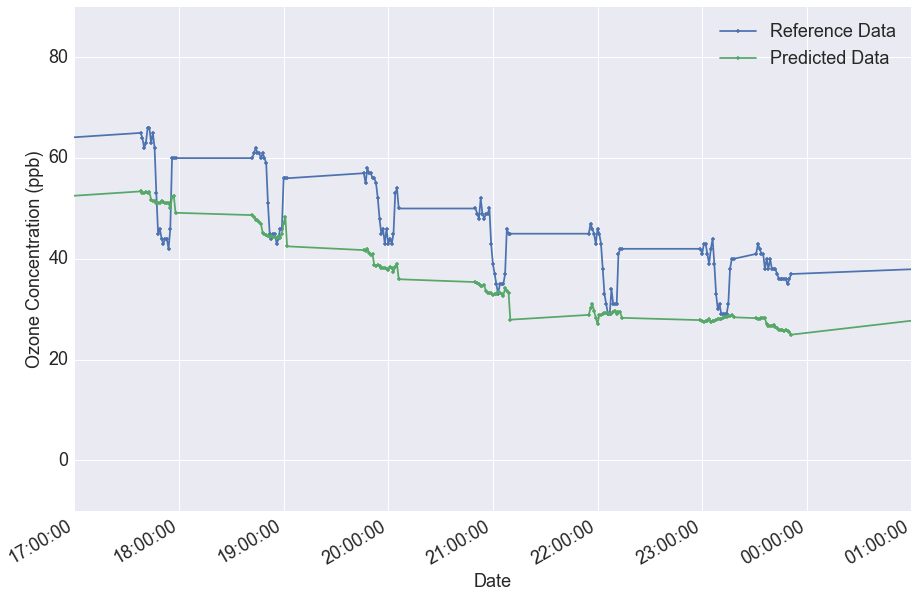

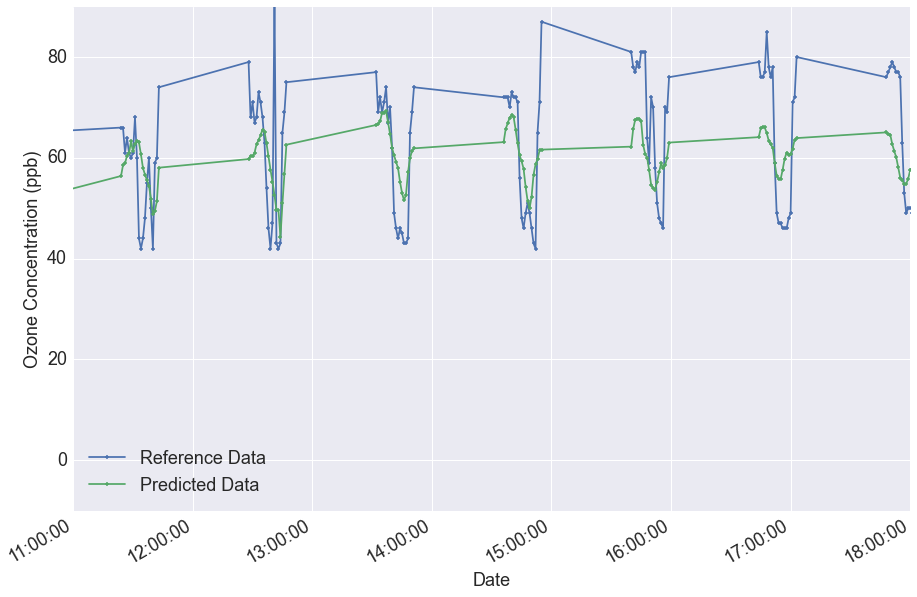

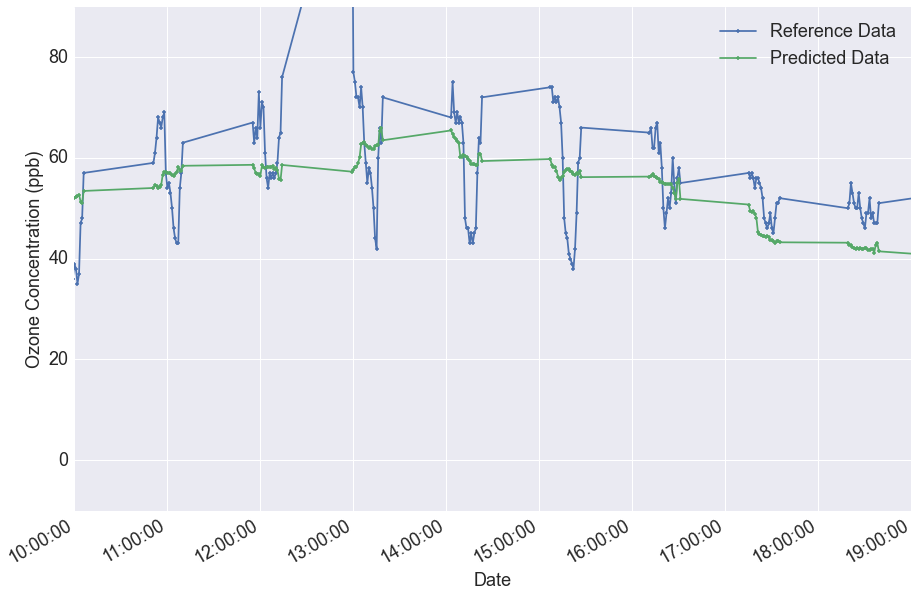

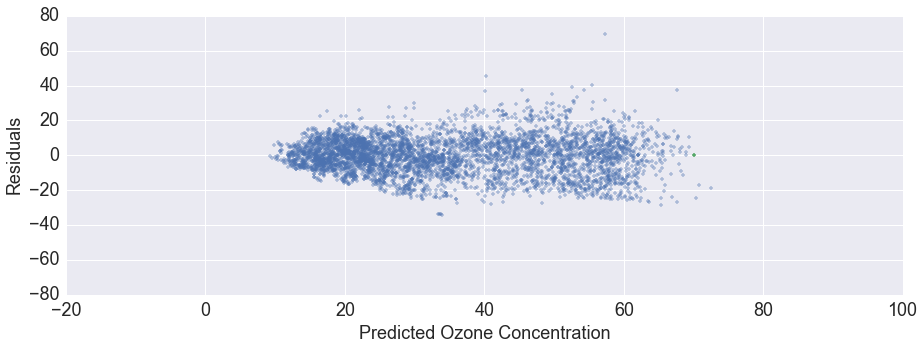

In [111]:
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_svm_fit_all, ref_column)

## Random Forest- All

In [109]:
MSE_CV, df_fit_rf = find_MSE_random_forest(df_fits, fs_features[:num_good_feat], days_tr, 0, ref_column)

7-27 Cross-Validation RMSE:  12.5
7-28 Cross-Validation RMSE:  14.8
7-29 Cross-Validation RMSE:  9.3
7-31 Cross-Validation RMSE:  14.0
8-1 Cross-Validation RMSE:  12.9
8-2 Cross-Validation RMSE:  10.6
8-3 Cross-Validation RMSE:  13.1
8-4 Cross-Validation RMSE:  11.2
8-5 Cross-Validation RMSE:  14.8
8-6 Cross-Validation RMSE:  10.7
8-7 Cross-Validation RMSE:  12.5
8-8 Cross-Validation RMSE:  11.5
8-9 Cross-Validation RMSE:  10.9
8-10 Cross-Validation RMSE:  11.5
8-11 Cross-Validation RMSE:  11.3
8-12 Cross-Validation RMSE:  5.7
Overall RMSE: 11.7006460519


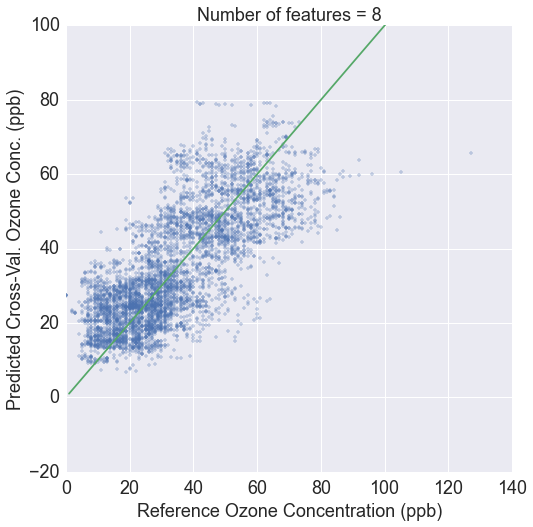

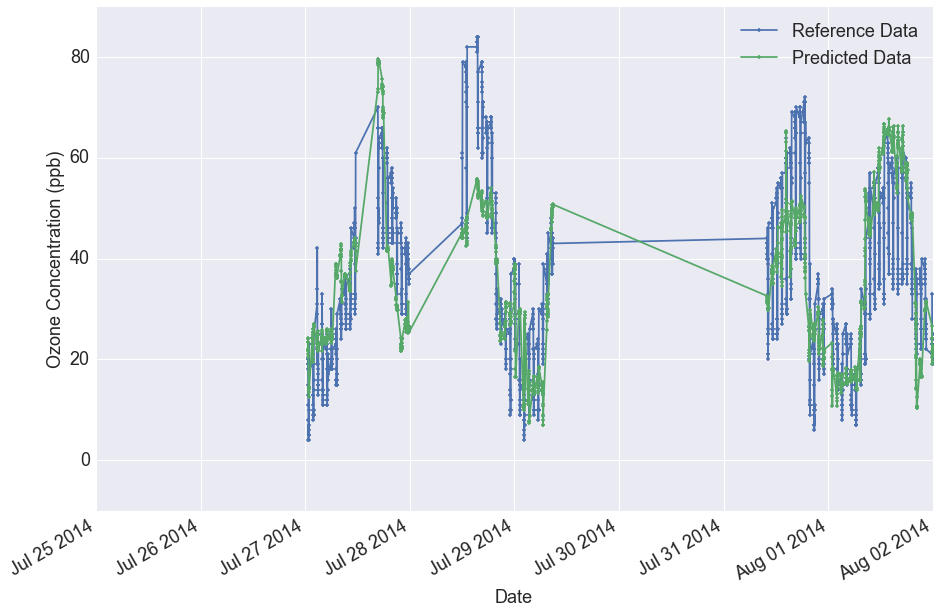

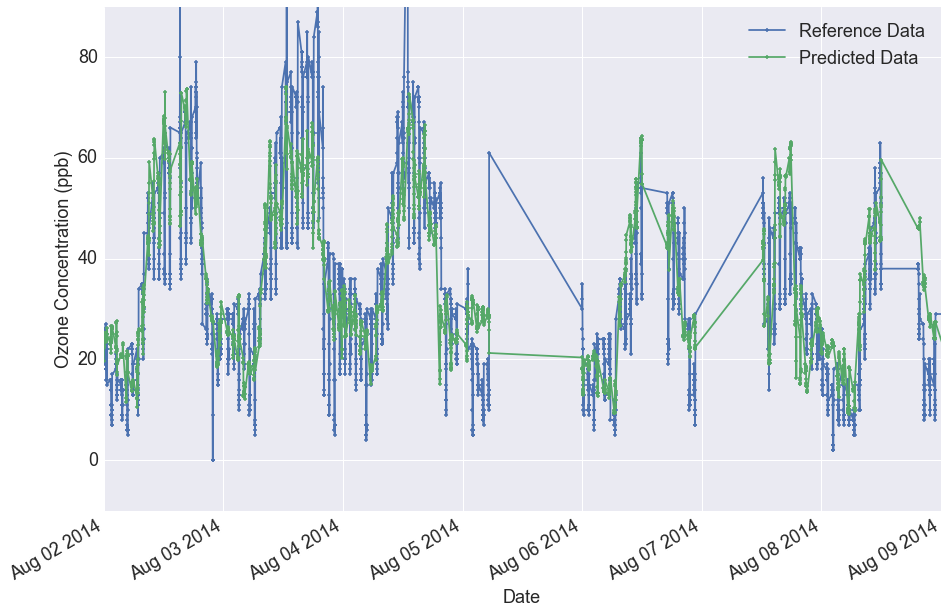

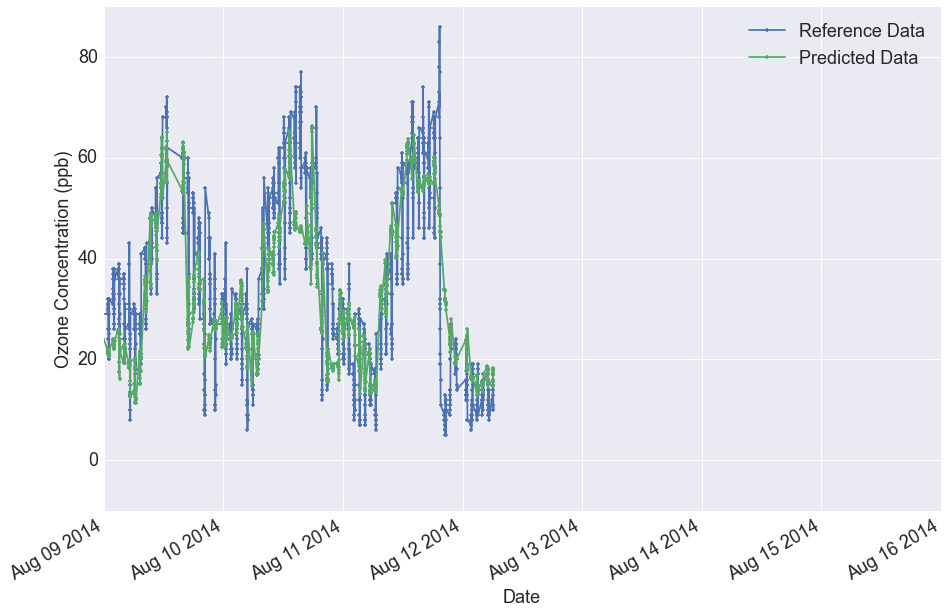

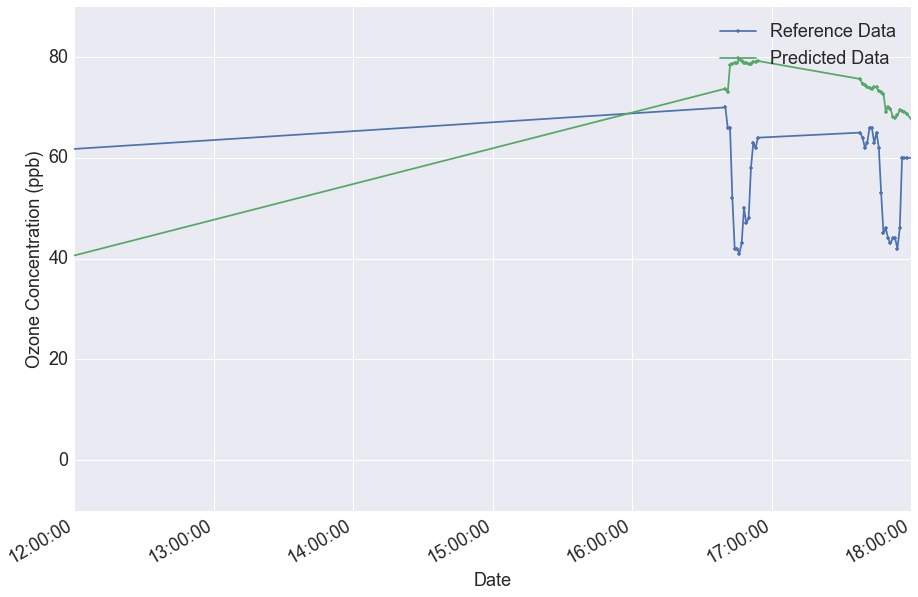

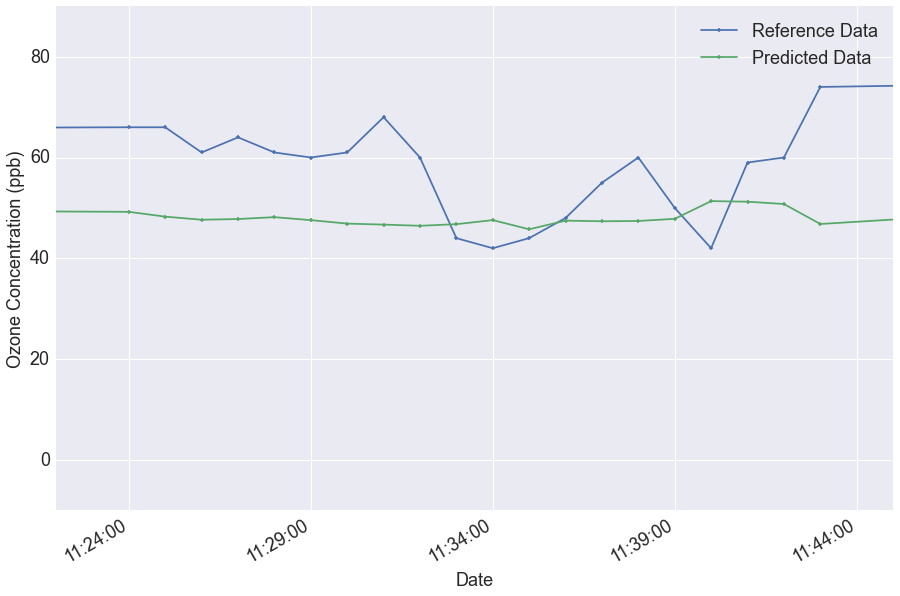

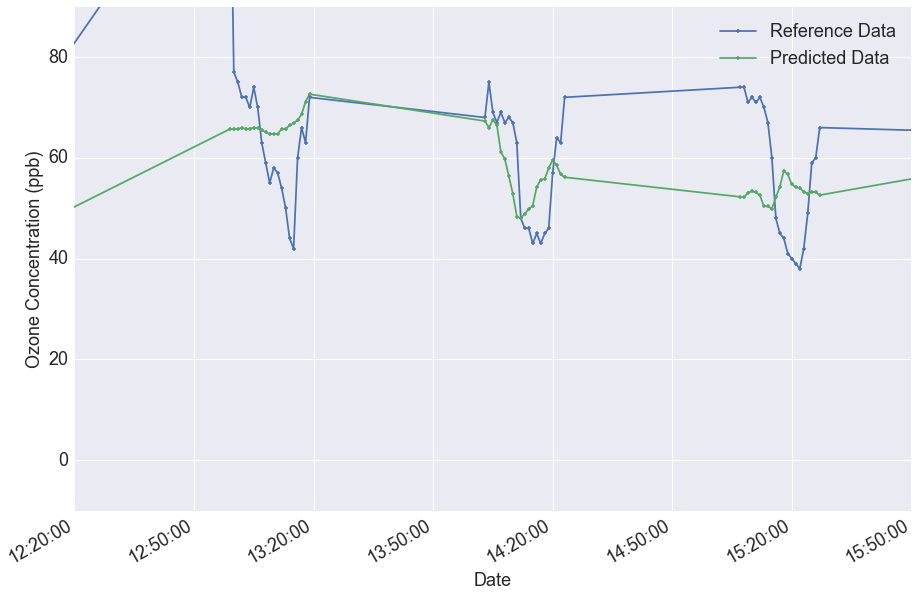

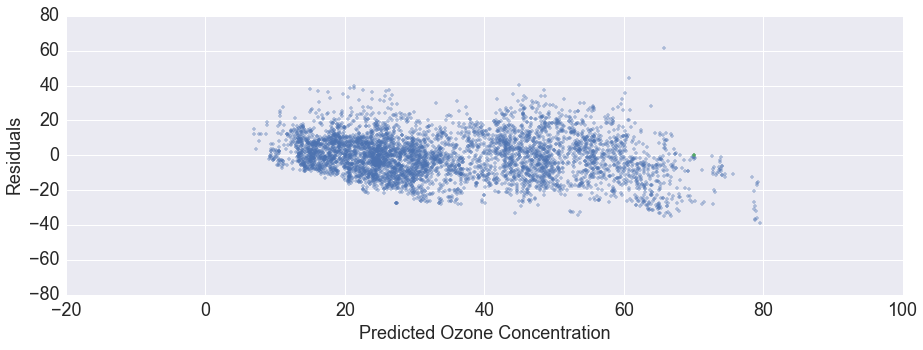

In [86]:
fitted_vs_ref_plot(df_fit_rf, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_fit_rf, ref_column)

## Random Forest- Base

In [108]:
MSE_CV_base, df_fit_rf_base = find_MSE_random_forest(df_fits, base_features, days_tr, 0, ref_column)

7-27 Cross-Validation RMSE:  13.6
7-28 Cross-Validation RMSE:  16.9
7-29 Cross-Validation RMSE:  9.7
7-31 Cross-Validation RMSE:  14.0
8-1 Cross-Validation RMSE:  12.5
8-2 Cross-Validation RMSE:  10.6
8-3 Cross-Validation RMSE:  13.8
8-4 Cross-Validation RMSE:  11.6
8-5 Cross-Validation RMSE:  15.0
8-6 Cross-Validation RMSE:  12.0
8-7 Cross-Validation RMSE:  11.6
8-8 Cross-Validation RMSE:  11.0
8-9 Cross-Validation RMSE:  11.6
8-10 Cross-Validation RMSE:  11.1
8-11 Cross-Validation RMSE:  11.5
8-12 Cross-Validation RMSE:  4.8
Overall RMSE: 11.9645417536


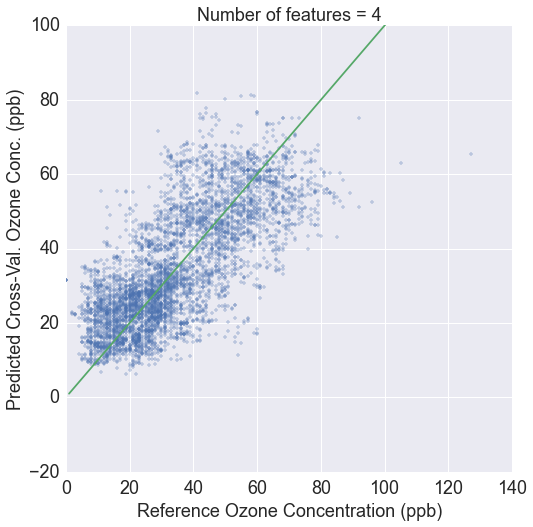

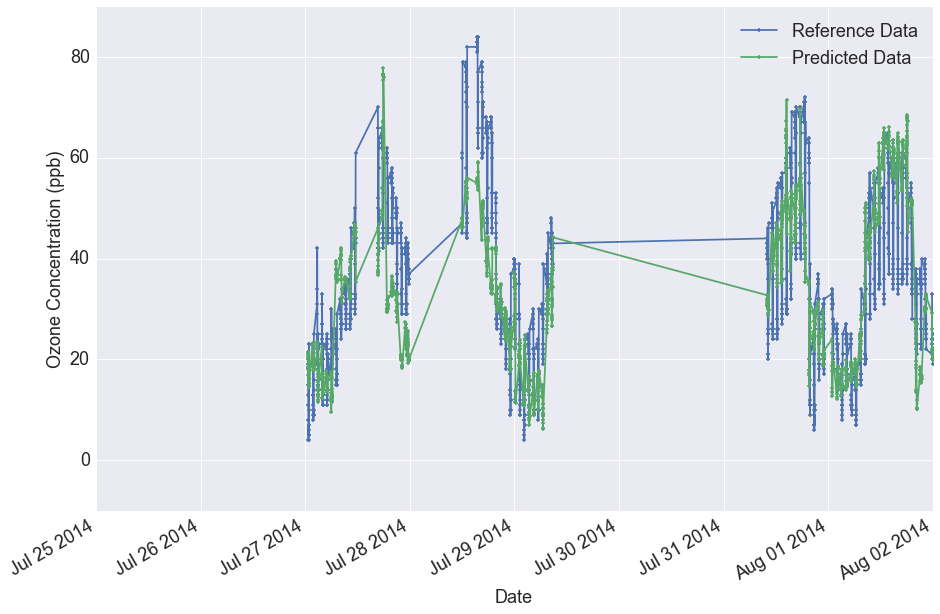

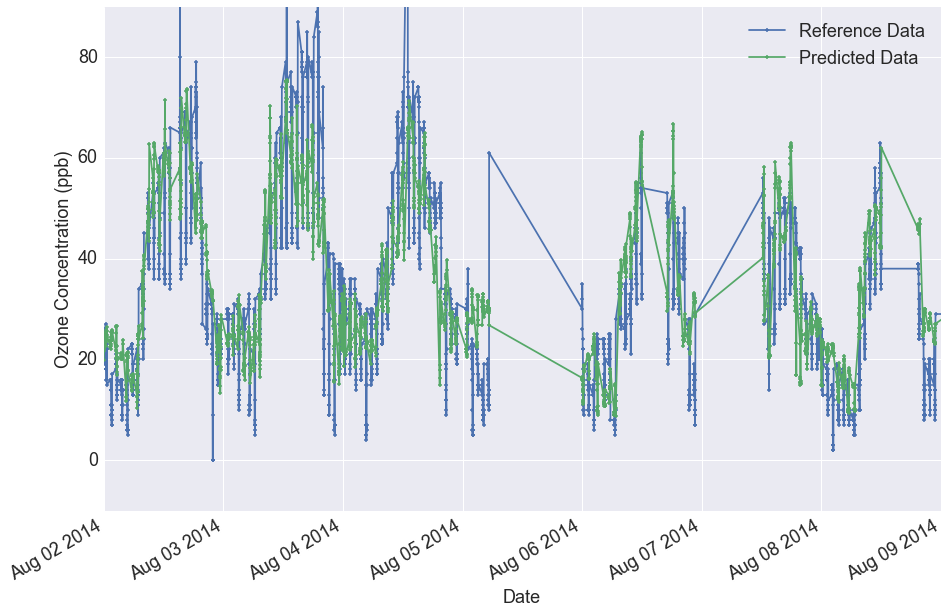

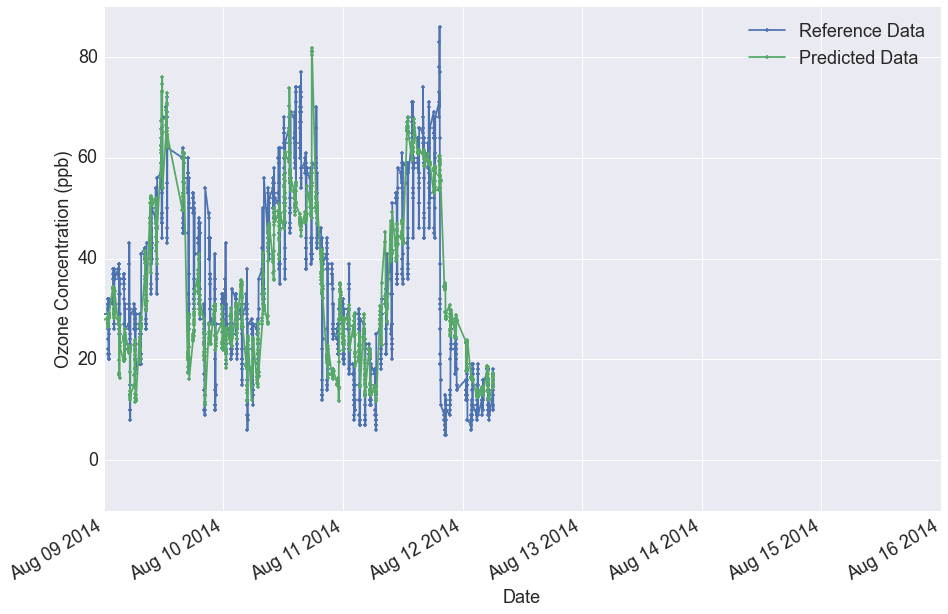

In [90]:
fitted_vs_ref_plot(df_fit_rf_base, 4, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 3, ref_column)

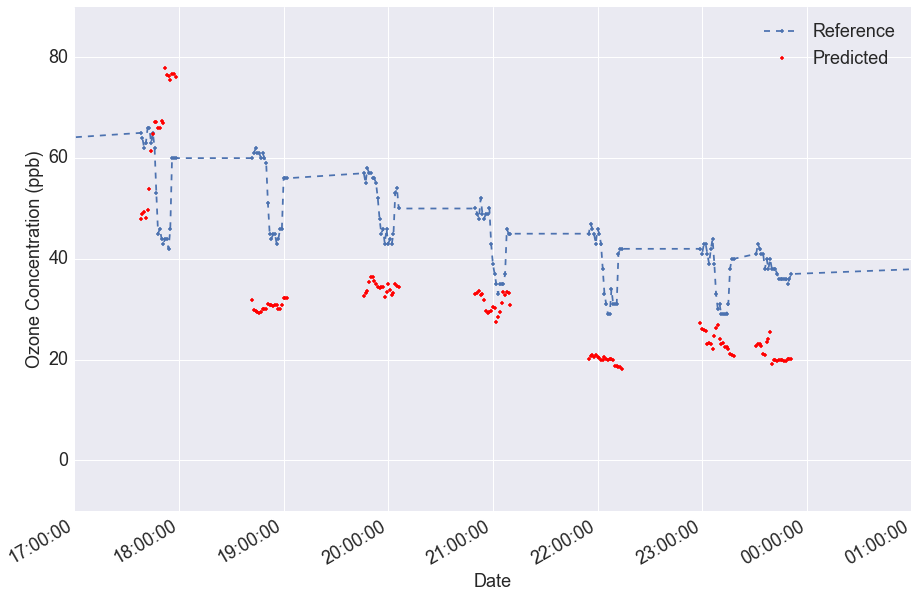

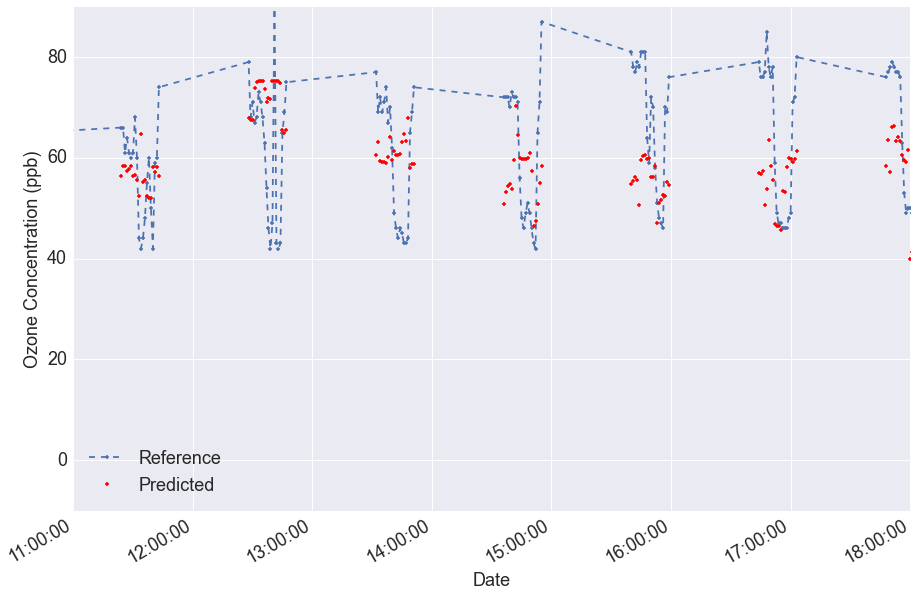

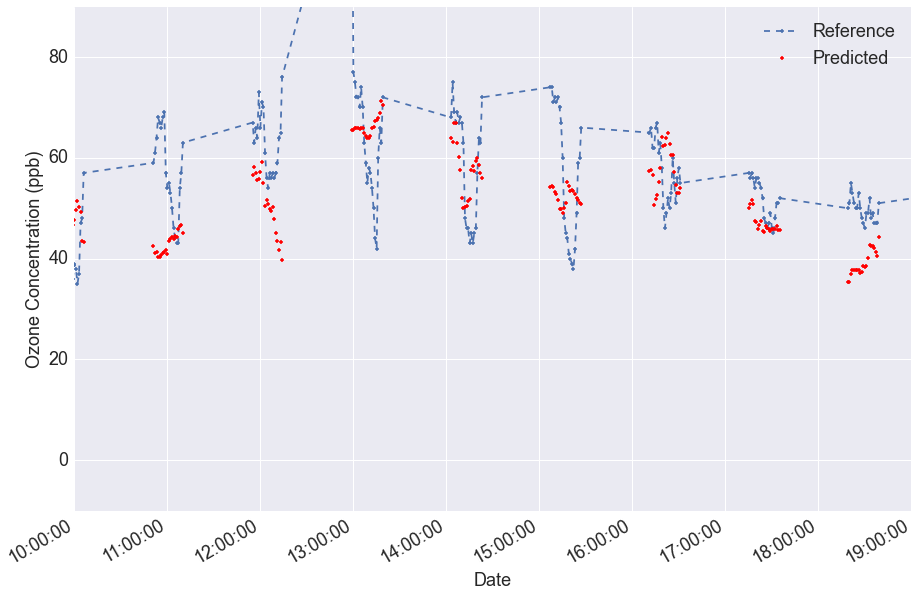

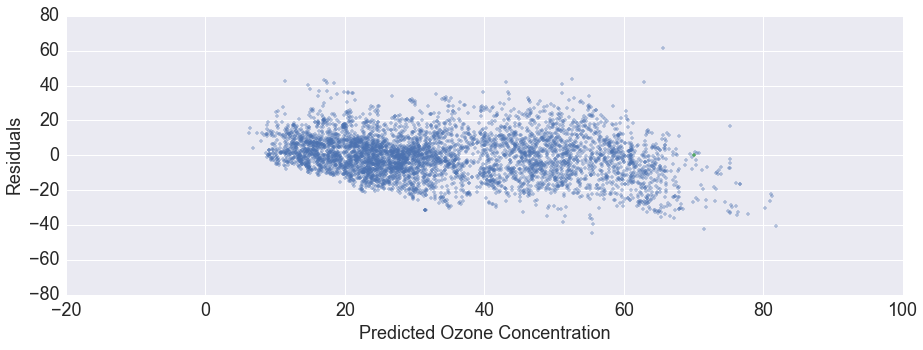

In [103]:
plot_fitted_and_ref_vs_time_no_lines(df_fit_rf_base, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time_no_lines(df_fit_rf_base, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time_no_lines(df_fit_rf_base, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_fit_rf_base, ref_column)